In [49]:
from datasets import load_from_disk    
import json
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
from qdrant_vector_store.data_embedding_utils import instantiate_model_and_tokenizer

In [54]:
# Define the overall storage folder path
folder_path = "local_chunk_dataset"

# Define the dataset folder path
dataset_path = "chunk3000_overlap500"

In [55]:
# Define the base directory for embedding models
QDRANT_STORE_LOCATION = 'qdrant_vector_store'
LOCAL_BASE_DIR = 'local_embedding_models'
MODEL_LOCATION = os.path.join(QDRANT_STORE_LOCATION, LOCAL_BASE_DIR)
MODEL_NAME = 'Snowflake/snowflake-arctic-embed-l-v2.0'
LOCAL_MODEL_DIR = os.path.join(MODEL_LOCATION, MODEL_NAME)

# Get embedding model and tokenizer from HuggingFace or local storage, load it to DEVICE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TOKENIZER, MODEL = instantiate_model_and_tokenizer(MODEL_NAME, DEVICE, LOCAL_MODEL_DIR)

qdrant_vector_store/local_embedding_models/Snowflake/snowflake-arctic-embed-l-v2.0
Loading Snowflake/snowflake-arctic-embed-l-v2.0 from local storage...


Some weights of XLMRobertaModel were not initialized from the model checkpoint at qdrant_vector_store/local_embedding_models/Snowflake/snowflake-arctic-embed-l-v2.0 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Snowflake/snowflake-arctic-embed-l-v2.0 embedding model loaded to cuda


# Load Dataset

## Data

In [56]:
# Actual path
full_path = os.path.join(folder_path, dataset_path)

# Load dataset
local_chunk_dataset = load_from_disk(full_path)

## Config During Generation

In [5]:
# Path to the config file
config_path = os.path.join(full_path, "chunk_config.json")

# Load the config
with open(config_path, "r") as f:
    config_metadata = json.load(f)

# Inspect the config
print("📋 Loaded Config Metadata:")
for key, value in config_metadata.items():
    print(f"{key}: {value}")

📋 Loaded Config Metadata:
chunk_char_length: 2500
chunk_overlap: 250
filter_applied: False
get_images: True
push_to_hub: False
hf_text_repo: JohnVitz/NLP_Final_Project_ArXiv_Parsed2
hf_image_repo: JohnVitz/NLP_Final_Project_ArXiv_Parsed_Images2
dataset_save_time: 2025-04-13T22:43:26.927770
source: /home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/get_chunks/raw_parsed_pdfs.pkl


In [6]:
CHUNK_CHAR_LENGTH = config_metadata['chunk_char_length']
CHUNK_OVERLAP = config_metadata['chunk_overlap']

In [7]:
local_chunk_dataset[0]

{'markdown_text': '## **Frustratingly Easy Domain Adaptation**  \n### **Hal Daum´e III** School of Computing University of Utah Salt Lake City, Utah 84112 `me@hal3.name`',
 'pdf_metadata': {'id': '0907.1815',
  'title': 'Frustratingly Easy Domain Adaptation',
  'categories': ['cs.LG', 'cs.CL']},
 'header_metadata': {'Header 1': None,
  'Header 2': '**Frustratingly Easy Domain Adaptation**',
  'Header 3': '**Hal Daum´e III** School of Computing University of Utah Salt Lake City, Utah 84112 `me@hal3.name`',
  'Header 4': None,
  'Header 5': None},
 'chunk_metadata': {'chunk_type': 'title'}}

# Category Level EDA

In [8]:
def get_categories(dataset, my_dict_for_cats={}):
    #temp_cats_list = example['pdf_metadata']['categories']
    for row in dataset:
        temp_cats_list = row['pdf_metadata']['categories']
        for category in temp_cats_list:

            temp_get = my_dict_for_cats.get(f'{category}', False)
            #print(temp_get)

            if temp_get:
                my_dict_for_cats[f'{category}'] += 1
            else:
                my_dict_for_cats[f'{category}'] = 1

    return my_dict_for_cats

In [9]:
my_dict = get_categories(local_chunk_dataset)
my_dict

{'cs.LG': 8555,
 'cs.CL': 3564,
 'cs.AI': 3176,
 'stat.ML': 3801,
 'math.OC': 301,
 'cs.MS': 120,
 'cs.IR': 105,
 'cs.NE': 1780,
 'cs.CV': 4008,
 'cond-mat.dis-nn': 63,
 'q-bio.NC': 63,
 'stat.CO': 36,
 'stat.ME': 36,
 'cs.DC': 225,
 'cs.RO': 180,
 'cs.GR': 71,
 'cs.CG': 75,
 'cs.SC': 40,
 'cs.CR': 320,
 'cs.SI': 137,
 'cs.SD': 68,
 'cs.DS': 42,
 'cs.IT': 30,
 'math.IT': 30,
 'cs.CY': 437,
 'cs.DB': 20,
 'cs.HC': 29,
 'math.PR': 36,
 'eess.IV': 91,
 'eess.AS': 34}

In [10]:
local_chunk_dataset[0]

{'markdown_text': '## **Frustratingly Easy Domain Adaptation**  \n### **Hal Daum´e III** School of Computing University of Utah Salt Lake City, Utah 84112 `me@hal3.name`',
 'pdf_metadata': {'id': '0907.1815',
  'title': 'Frustratingly Easy Domain Adaptation',
  'categories': ['cs.LG', 'cs.CL']},
 'header_metadata': {'Header 1': None,
  'Header 2': '**Frustratingly Easy Domain Adaptation**',
  'Header 3': '**Hal Daum´e III** School of Computing University of Utah Salt Lake City, Utah 84112 `me@hal3.name`',
  'Header 4': None,
  'Header 5': None},
 'chunk_metadata': {'chunk_type': 'title'}}

In [11]:
# Extract all nested category lists into a flat list
categories_nested = [example['pdf_metadata']['categories'] for example in local_chunk_dataset]
categories_flat = list(itertools.chain.from_iterable(categories_nested))

# Get unique categories
unique_categories = set(categories_flat)
print(f"🔢 Total Unique Categories: {len(unique_categories)}")
print(f"📚 Unique Categories:\n{sorted(unique_categories)}")

🔢 Total Unique Categories: 30
📚 Unique Categories:
['cond-mat.dis-nn', 'cs.AI', 'cs.CG', 'cs.CL', 'cs.CR', 'cs.CV', 'cs.CY', 'cs.DB', 'cs.DC', 'cs.DS', 'cs.GR', 'cs.HC', 'cs.IR', 'cs.IT', 'cs.LG', 'cs.MS', 'cs.NE', 'cs.RO', 'cs.SC', 'cs.SD', 'cs.SI', 'eess.AS', 'eess.IV', 'math.IT', 'math.OC', 'math.PR', 'q-bio.NC', 'stat.CO', 'stat.ME', 'stat.ML']


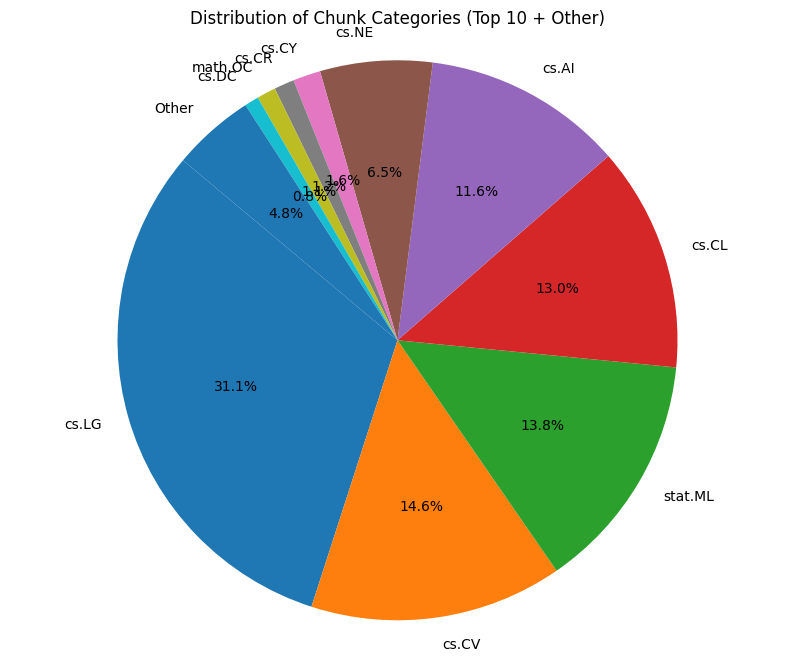

In [12]:
# Sort categories by count (optional, for better visuals)
sorted_categories = dict(sorted(my_dict.items(), key=lambda item: item[1], reverse=True))

# Prepare labels and sizes
labels = list(sorted_categories.keys())
sizes = list(sorted_categories.values())

# Optional: Limit number of slices shown for readability (e.g., top 10)
top_n = 10
labels = labels[:top_n] + ['Other']
sizes = sizes[:top_n] + [sum(sizes[top_n:])]

# Plot pie chart
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Chunk Categories (Top 10 + Other)")
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()

In [13]:
from collections import Counter
from itertools import combinations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compute_strict_topk_category_cooccurrence(dataset, category_field='pdf_metadata', subfield='categories', top_k=10):
    """
    Computes a pairwise co-occurrence matrix for the top-k categories.
    All other categories are grouped into a single 'Other' bucket.

    Parameters:
    - dataset: Hugging Face Dataset
    - category_field: Top-level key (e.g., 'pdf_metadata')
    - subfield: Key inside top-level dict (e.g., 'categories')
    - top_k: Number of top categories to retain; all others become 'Other'

    Returns:
    - cooccurrence_df: DataFrame for heatmap visualization
    """
    number_of_dataset_chunks = len(dataset)

    # Count frequency of all categories
    category_counter = Counter()
    for example in dataset:
        for cat in example[category_field][subfield]:
            category_counter[cat] += 1

    # Identify top-k categories
    top_categories = set([cat for cat, _ in category_counter.most_common(top_k)])

    # Initialize co-occurrence counter
    cooccur_counter = Counter()

    for example in dataset:
        original_cats = example[category_field][subfield]
        grouped_cats = [cat if cat in top_categories else "Other" for cat in original_cats]
        unique_grouped = sorted(set(grouped_cats))

        for pair in combinations(unique_grouped, 2):
            cooccur_counter[pair] += 1

    # Build symmetric matrix
    matrix_labels = sorted(top_categories.union({"Other"}))
    cooccurrence_df = pd.DataFrame(0, index=matrix_labels, columns=matrix_labels)

    for (a, b), count in cooccur_counter.items():
        cooccurrence_df.loc[a, b] += count
        cooccurrence_df.loc[b, a] += count  # symmetric

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccurrence_df, cmap="Blues", annot=True, fmt=".0f")
    plt.title(f"Top {top_k} Category Co-occurrence Matrix (n={number_of_dataset_chunks})")
    plt.tight_layout()
    plt.show()

    return cooccurrence_df

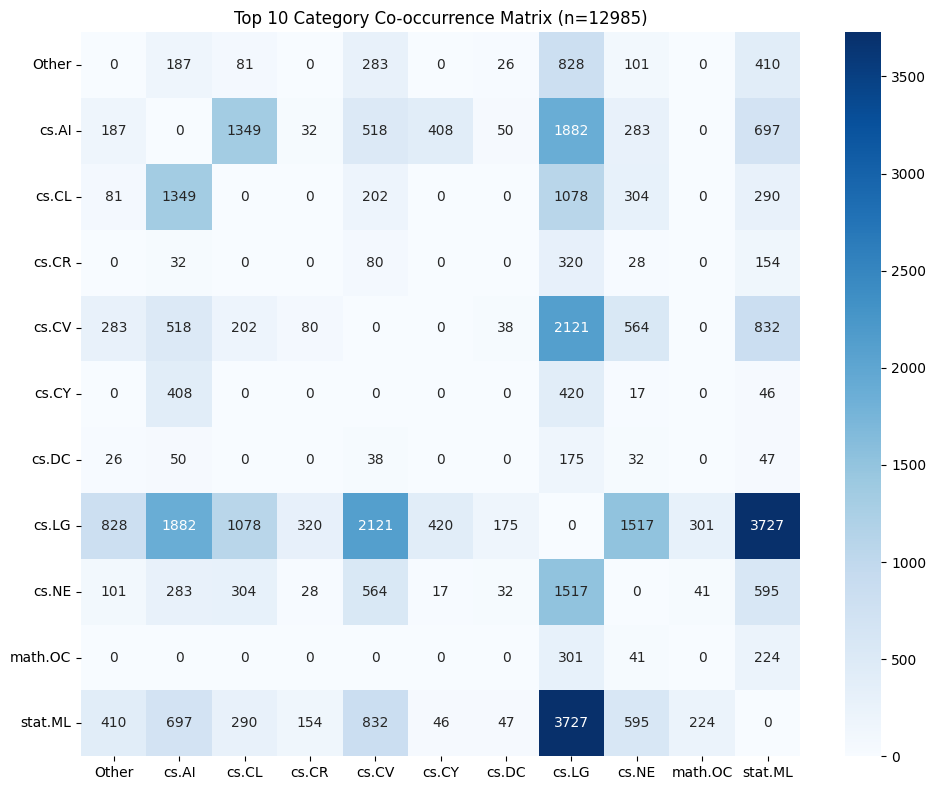

In [14]:
cooccur_df = compute_strict_topk_category_cooccurrence(local_chunk_dataset)

# Creating plaintext field, as this is what is actually passed to the embedding model to generate embedding vectors

In [15]:

from qdrant_vector_store.data_embedding_utils import markdown_to_text

def add_plaintext_field(example):
    example["plaintext"] = markdown_to_text(example["markdown_text"])
    return example

# Apply it to the dataset
local_chunk_dataset = local_chunk_dataset.map(add_plaintext_field)

local_chunk_dataset[0]

{'markdown_text': '## **Frustratingly Easy Domain Adaptation**  \n### **Hal Daum´e III** School of Computing University of Utah Salt Lake City, Utah 84112 `me@hal3.name`',
 'pdf_metadata': {'id': '0907.1815',
  'title': 'Frustratingly Easy Domain Adaptation',
  'categories': ['cs.LG', 'cs.CL']},
 'header_metadata': {'Header 1': None,
  'Header 2': '**Frustratingly Easy Domain Adaptation**',
  'Header 3': '**Hal Daum´e III** School of Computing University of Utah Salt Lake City, Utah 84112 `me@hal3.name`',
  'Header 4': None,
  'Header 5': None},
 'chunk_metadata': {'chunk_type': 'title'},
 'plaintext': 'Frustratingly Easy Domain Adaptation\nHal Daum´e III School of Computing University of Utah Salt Lake City, Utah 84112 me@hal3.name'}

# Character Level EDA

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_chunk_char_length_distribution(dataset, field="markdown_text"):
    # Compute character lengths
    chunk_lengths = [len(example[field]) for example in dataset]

    # Calculate summary statistics
    mean_length = np.mean(chunk_lengths)
    median_length = np.median(chunk_lengths)
    min_length = np.min(chunk_lengths)
    max_length = np.max(chunk_lengths)
    std_length = np.std(chunk_lengths)

    # Print summary statistics
    print("📊 Chunk Character Length Summary:")
    print(f"• Mean: {mean_length:.2f}")
    print(f"• Median: {median_length}")
    print(f"• Min: {min_length}")
    print(f"• Max: {max_length}")
    print(f"• Std Dev: {std_length:.2f}")

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(chunk_lengths, bins=50, color='skyblue', edgecolor='black')
    plt.xlabel("Chunk Character Length")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Chunk Lengths (n={len(chunk_lengths)} chunks)\n"
              f"Mean={mean_length:.0f}, Median={median_length}, Std={std_length:.0f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

📊 Chunk Character Length Summary:
• Mean: 1845.96
• Median: 2406.0
• Min: 1
• Max: 2500
• Std Dev: 828.40


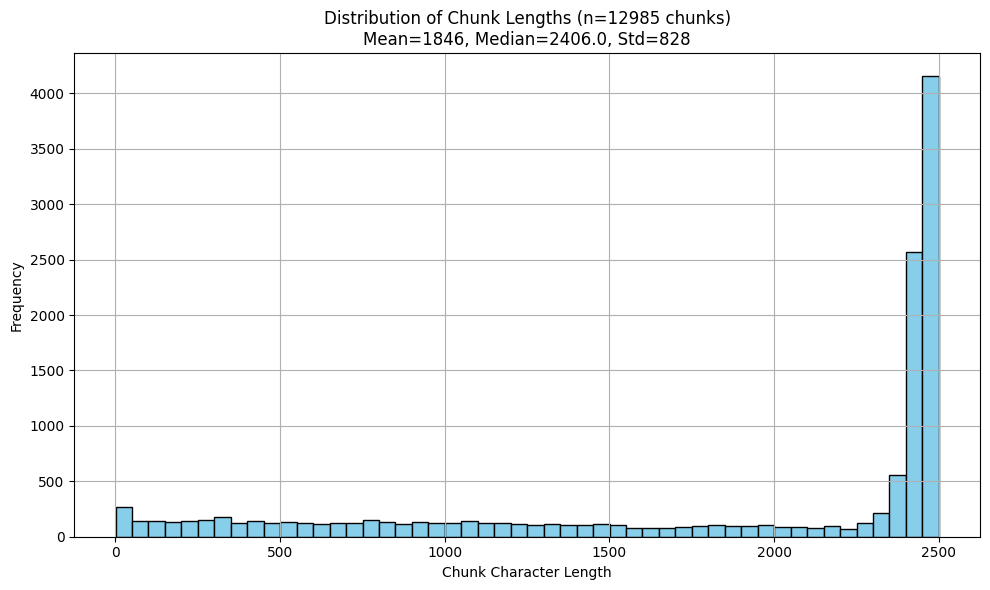

In [17]:
plot_chunk_char_length_distribution(local_chunk_dataset, field="markdown_text")

📊 Chunk Character Length Summary:
• Mean: 1702.16
• Median: 2097.0
• Min: 0
• Max: 2498
• Std Dev: 795.21


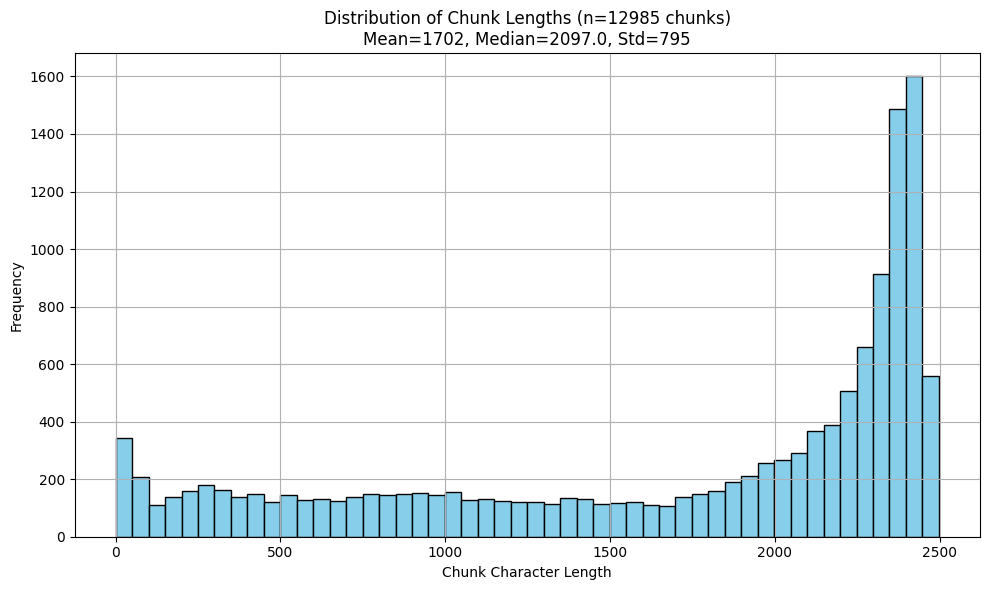

In [18]:
plot_chunk_char_length_distribution(local_chunk_dataset, field="plaintext")

We have a fat tailed, skewed left distribution of chunk lengths, which means that we have to deal with this as best we can.

# Character Level Comprehensive Metrics Generation

In [19]:
def promote_chunk_type_field(example):
    example["chunk_type"] = example["chunk_metadata"]["chunk_type"]
    return example

local_chunk_dataset = local_chunk_dataset.map(promote_chunk_type_field)
local_chunk_dataset

Dataset({
    features: ['markdown_text', 'pdf_metadata', 'header_metadata', 'chunk_metadata', 'plaintext', 'chunk_type'],
    num_rows: 12985
})

In [20]:
from collections import Counter
import math
import string

def compute_all_char_metrics(example):
    """
    Compute all character-level metrics from the `plaintext` of a chunk.
    These metrics help identify noisy, low-information, or anomalous chunks
    before embeddings are generated.

    Returns a dictionary with the following fields:
    - alphabetic_char_ratio: Proportion of alphabetic characters to total
    - numeric_char_ratio: Proportion of numeric characters (0-9)
    - punctuation_char_ratio: Proportion of standard punctuation marks
    - whitespace_char_ratio: Proportion of whitespace (spaces, tabs, etc.)
    - newline_ratio: Proportion of newline characters
    - symbol_ratio: All other characters not covered above
    - pipe_to_alnum_ratio: Ratio of '|' chars to alphanumeric chars (useful for detecting table-like noise)
    - char_length: Total number of characters in the chunk
    - char_entropy: Shannon entropy of the character distribution — lower = repetitive, higher = diverse
    - unique_char_ratio: Unique characters divided by total characters
    - top1_char_ratio: Frequency of most common character over total
    - top3_char_ratio: Sum of frequencies of top 3 characters over total
    """
    
    text = example["plaintext"]
    text_lower = text.lower()
    total_chars = len(text)

    # Early exit for empty strings
    if total_chars == 0:
        return {
            "alphabetic_char_ratio": 0.0,
            "numeric_char_ratio": 0.0,
            "punctuation_char_ratio": 0.0,
            "whitespace_char_ratio": 0.0,
            "newline_ratio": 0.0,
            "symbol_ratio": 0.0,
            "pipe_to_alnum_ratio": 0.0,
            "char_length": 0,
            "char_entropy": 0.0,
            "unique_char_ratio": 0.0,
            "top1_char_ratio": 0.0,
            "top3_char_ratio": 0.0,
        }

    # Base character category counts
    alphabetic = sum(c.isalpha() for c in text)
    numeric = sum(c.isdigit() for c in text)
    punctuation = sum(c in string.punctuation for c in text)
    whitespace = sum(c.isspace() for c in text)
    newlines = text.count('\n')
    symbols = total_chars - (alphabetic + numeric + punctuation + whitespace)

    # Pipe to alphanumeric ratio
    pipe_count = text.count('|')
    alnum_count = sum(c.isalnum() for c in text)
    pipe_ratio = pipe_count / alnum_count if alnum_count > 0 else 0.0

    # Entropy-based metrics
    char_counts = Counter(text_lower)
    entropy = -sum((count / total_chars) * math.log2(count / total_chars) for count in char_counts.values())

    # Top N character ratios
    sorted_counts = sorted(char_counts.values(), reverse=True)
    top1_ratio = sorted_counts[0] / total_chars if sorted_counts else 0.0
    top3_ratio = sum(sorted_counts[:3]) / total_chars if len(sorted_counts) >= 3 else top1_ratio

    return {
        "alphabetic_char_ratio": alphabetic / total_chars,
        "numeric_char_ratio": numeric / total_chars,
        "punctuation_char_ratio": punctuation / total_chars,
        "whitespace_char_ratio": whitespace / total_chars,
        "newline_ratio": newlines / total_chars,
        "symbol_ratio": symbols / total_chars,
        "pipe_to_alnum_ratio": pipe_ratio,
        "char_length": total_chars,
        "char_entropy": entropy,
        "unique_char_ratio": len(char_counts) / total_chars,
        "top1_char_ratio": top1_ratio,
        "top3_char_ratio": top3_ratio
    }


In [21]:
local_chunk_dataset = local_chunk_dataset.map(compute_all_char_metrics)

In [22]:
local_chunk_dataset

Dataset({
    features: ['markdown_text', 'pdf_metadata', 'header_metadata', 'chunk_metadata', 'plaintext', 'chunk_type', 'alphabetic_char_ratio', 'numeric_char_ratio', 'punctuation_char_ratio', 'whitespace_char_ratio', 'newline_ratio', 'symbol_ratio', 'pipe_to_alnum_ratio', 'char_length', 'char_entropy', 'unique_char_ratio', 'top1_char_ratio', 'top3_char_ratio'],
    num_rows: 12985
})

In [23]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

def summarize_char_metrics_from_dataset(hf_dataset, metric_fields=None, filter_field=None, filter_value=None):
    """
    Converts HF dataset to DataFrame and computes extended descriptive statistics for character-level metrics.

    Parameters:
    - hf_dataset (Dataset): HuggingFace Dataset with character metrics
    - metric_fields (list): List of metric field names to summarize (optional)
    - filter_field (str): Top-level field to filter by (e.g., "chunk_type")
    - filter_value (Any): Value to match for filtering (e.g., "body")

    Returns:
    - pd.DataFrame: Summary statistics for each metric
    """

    # Apply filter at top level if provided
    if filter_field and filter_value is not None:
        hf_dataset = hf_dataset.filter(lambda x: x[filter_field] == filter_value)

    # Convert to DataFrame
    df = hf_dataset.to_pandas()

    # Automatically select relevant metrics if none are specified
    if metric_fields is None:
        metric_fields = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]

    summary_data = []

    for field in metric_fields:
        values = df[field].dropna()

        if len(values) == 0:
            continue

        # Quantiles and bounds for outlier detection
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Collect statistics for each metric
        summary_data.append({
            "Metric": field,
            "Mean": np.mean(values),                  # Average value
            "Median": np.median(values),              # Middle value (50th percentile)
            "Mode": values.mode().iloc[0] if not values.mode().empty else np.nan,  # Most common value
            "Std": np.std(values),                    # Standard deviation (spread of data)
            "2 Std": np.std(values) * 2,              # Two standard deviations (for filtering bounds)
            "3 Std": np.std(values) * 3,              # Three standard deviations (for stricter filtering)
            "Min": np.min(values),                    # Minimum value
            "Max": np.max(values),                    # Maximum value
            "Skew": skew(values),                     # Skewness (asymmetry of distribution)
            "Kurtosis": kurtosis(values),             # Kurtosis (tailedness of distribution)
            "IQR": iqr,                               # Interquartile Range (spread of the middle 50%)
            "% Zero": (values == 0).sum() / len(values),  # Proportion of chunks with zero for this metric
            "% Outliers Low": (values < lower_bound).sum() / len(values),  # Fraction of chunks below IQR-1.5
            "% Outliers High": (values > upper_bound).sum() / len(values), # Fraction of chunks above IQR+1.5
            "Unique Value Count": values.nunique(),   # Number of unique values
            "Support Count": len(values)              # Total number of non-null entries
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

In [24]:
character_metrics_summary_df = summarize_char_metrics_from_dataset(local_chunk_dataset)
character_metrics_summary_df

,Metric,Mean,Median,Mode,Std,2 Std,3 Std,Min,Max,Skew,Kurtosis,IQR,% Zero,% Outliers Low,% Outliers High,Unique Value Count,Support Count
0,alphabetic_char_ratio,0.716284,0.758735,0.0,0.146207,0.292414,0.438621,0.0,1.000000,-2.977006,10.141990,0.100023,0.015171,0.080169,0.000539,11826,12985
1,numeric_char_ratio,0.050787,0.020051,0.0,0.120769,0.241539,0.362308,0.0,1.000000,6.313338,44.246941,0.043364,0.046515,0.000000,0.063997,10643,12985
2,punctuation_char_ratio,0.061258,0.044385,0.0,0.056506,0.113011,0.169517,0.0,1.000000,4.553152,43.968562,0.045882,0.020716,0.000000,0.060685,11174,12985
3,whitespace_char_ratio,0.164999,0.159091,0.0,0.041692,0.083383,0.125075,0.0,0.516129,0.868243,8.444256,0.027828,0.014555,0.022179,0.076319,10921,12985
4,newline_ratio,0.013816,0.012494,0.0,0.010652,0.021305,0.031957,0.0,0.428571,11.541065,282.276767,0.005583,0.047670,0.058529,0.049827,7959,12985
5,symbol_ratio,0.004978,0.001669,0.0,0.015362,0.030724,0.046087,0.0,0.949153,26.258739,1304.851715,0.004512,0.291721,0.000000,0.101502,6127,12985
6,pipe_to_alnum_ratio,0.006484,0.000000,0.0,0.049663,0.099325,0.148988,0.0,2.578512,27.035421,1049.554661,0.000000,0.815941,0.000000,0.184059,2223,12985
7,char_length,1702.159184,2097.000000,2.0,795.208780,1590.417560,2385.626341,0.0,2498.000000,-0.829632,-0.788135,1321.000000,0.001694,0.000000,0.000000,2371,12985
8,char_entropy,4.418647,4.466177,0.0,0.521138,1.042276,1.563414,-0.0,5.043861,-6.162250,44.106944,0.250870,0.006161,0.036735,0.000847,12750,12985
9,unique_char_ratio,0.058621,0.023692,1.0,0.127917,0.255834,0.383750,0.0,1.000000,5.673310,35.321691,0.018319,0.001694,0.000000,0.144166,8962,12985


In [25]:
# Can also apply filter:

#body_character_metrics_summary_df = summarize_char_metrics_from_dataset(local_chunk_dataset, filter_field="chunk_type", filter_value="body")
#references_character_metrics_summary_df = summarize_char_metrics_from_dataset(local_chunk_dataset, filter_field="chunk_type", filter_value="references")
#title_character_metrics_summary_df = summarize_char_metrics_from_dataset(local_chunk_dataset, filter_field="chunk_type", filter_value="title")

# Basic Example of Usage of Character Level Statistics

This is a very crude example of the use of metrics, in reality using metrics should be done via testing results. However, due to time constraints, we are going to have to go off of sheer qualitative observation of the impact of applying different filters to the data.

## The Key Challenge Here is not the metrics gathering, it is determining if the metrics are actually relevant or will allow us to increase the quality of our body chunks (our knowledge base chunks)

In [26]:
def get_outlier_indices_by_metric(dataset, summary_df, std_multiplier=2, filter_field=None, filter_value=None):
    """
    Returns a dictionary mapping each metric to a list of dataset indices that are outliers
    based on Median ± (N * Std) thresholds.

    Parameters:
    - dataset (Dataset or pd.DataFrame): The dataset containing character-level metric fields.
    - summary_df (pd.DataFrame): Summary table with 'Metric', 'Median', and 'Std' columns.
    - std_multiplier (int or float): Multiplier of standard deviation used to define outlier bounds.

    Returns:
    - dict: {metric_name: list of index positions of outliers in the dataset}
    """
    import numpy as np

    # Convert from HF Dataset if needed
    df = dataset.to_pandas() if not isinstance(dataset, pd.DataFrame) else dataset
    outlier_indices = {}

    for _, row in summary_df.iterrows():
        metric = row["Metric"]
        if metric not in df.columns:
            continue

        median = row["Median"]
        std = row["Std"]
        lower = median - std_multiplier * std
        upper = median + std_multiplier * std

        # Get indices where values fall outside of the std bounds
        indices = df[(df[metric] < lower) | (df[metric] > upper)].index.tolist()
        outlier_indices[metric] = indices

    return outlier_indices

In [27]:
def get_outlier_indices_by_metric(dataset, summary_df, std_multiplier=2, filter_field=None, filter_value=None):
    """
    Returns a dictionary mapping each metric to a list of dataset indices that are outliers
    based on Median ± (N * Std) thresholds, with optional filtering by a specific field.

    Parameters:
    - dataset (Dataset or pd.DataFrame): The dataset containing character-level metric fields.
    - summary_df (pd.DataFrame): Summary table with 'Metric', 'Median', and 'Std' columns.
    - std_multiplier (int or float): Multiplier of standard deviation used to define outlier bounds.
    - filter_field (str, optional): Column name to filter by (e.g., 'chunk_type').
    - filter_value (any, optional): Value that the filter_field must match to retain the row.

    Returns:
    - dict: {metric_name: list of index positions of outliers in the dataset}
    """
    import numpy as np

    # Convert from HF Dataset if needed
    df = dataset.to_pandas() if not isinstance(dataset, pd.DataFrame) else dataset

    # Apply optional filtering
    if filter_field and filter_value is not None:
        df = df[df[filter_field] == filter_value]

    outlier_indices = {}

    for _, row in summary_df.iterrows():
        metric = row["Metric"]
        if metric not in df.columns:
            continue

        median = row["Median"]
        std = row["Std"]
        lower = median - std_multiplier * std
        upper = median + std_multiplier * std

        indices = df[(df[metric] < lower) | (df[metric] > upper)].index.tolist()
        outlier_indices[metric] = indices

    return outlier_indices

In [28]:
import matplotlib.pyplot as plt

def plot_metric_outlier_histograms_from_hf_dataset(
    hf_dataset,
    outlier_indices_dict,
    metrics_summary,
    std_multiplier=2,
    chunk_type_filter=None,
    bins=50,
    max_plots=None
):
    """
    Plots histograms of outlier vs non-outlier values for each metric using HuggingFace dataset.

    Parameters:
        hf_dataset (Dataset): Your HuggingFace dataset.
        outlier_indices_dict (dict): {metric: [indices]} from get_outlier_indices_by_metric.
        metrics_summary (pd.DataFrame): Summary stats for each metric (used for bounds & filtering).
        std_multiplier (int): Number of stds for threshold.
        chunk_type_filter (str): Optional filter by chunk type.
        bins (int): Number of histogram bins.
        max_plots (int): Limit number of metrics to plot (optional).
    """

    metrics_to_plot = list(outlier_indices_dict.keys())
    if max_plots:
        metrics_to_plot = metrics_to_plot[:max_plots]

    for metric in metrics_to_plot:
        outlier_indices = set(outlier_indices_dict[metric])

        non_outliers = []
        outliers = []

        for i, example in enumerate(hf_dataset):
            if chunk_type_filter and example.get("chunk_type") != chunk_type_filter:
                continue
            value = example.get(metric)
            if value is None:
                continue
            if i in outlier_indices:
                outliers.append(value)
            else:
                non_outliers.append(value)

        # Plot
        plt.figure(figsize=(8, 5))
        plt.hist(non_outliers, bins=bins, alpha=0.6, label="Not Outlier", color="green", edgecolor='black')
        plt.hist(outliers, bins=bins, alpha=0.6, label="Outlier", color="red", edgecolor='black')

        title = f"{metric} (Outlier Detection: ±{std_multiplier} std)"
        if chunk_type_filter:
            title += f" | Chunk Type: {chunk_type_filter}"

        plt.title(title)
        plt.xlabel(metric.replace("_", " ").title())
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

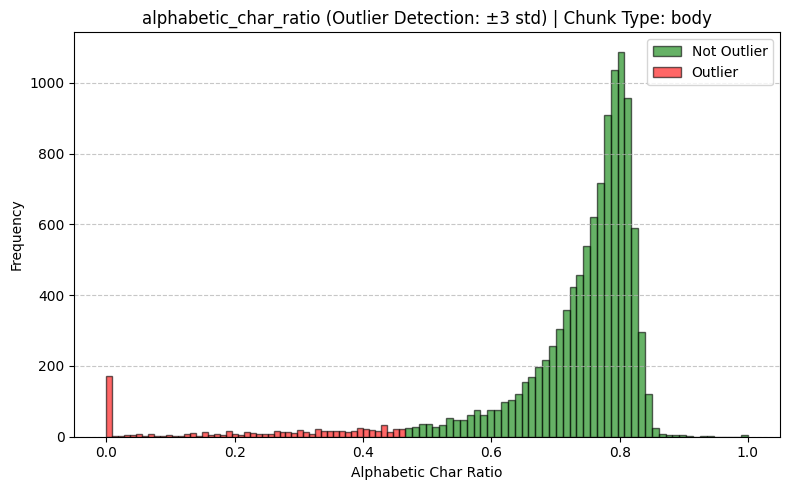

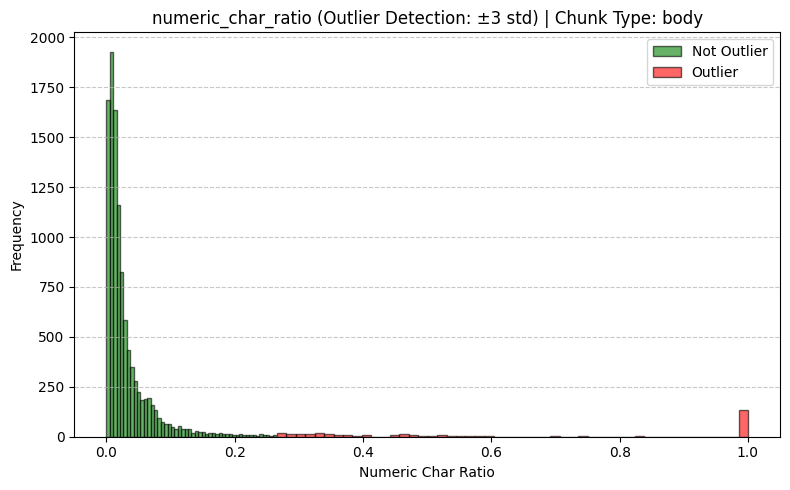

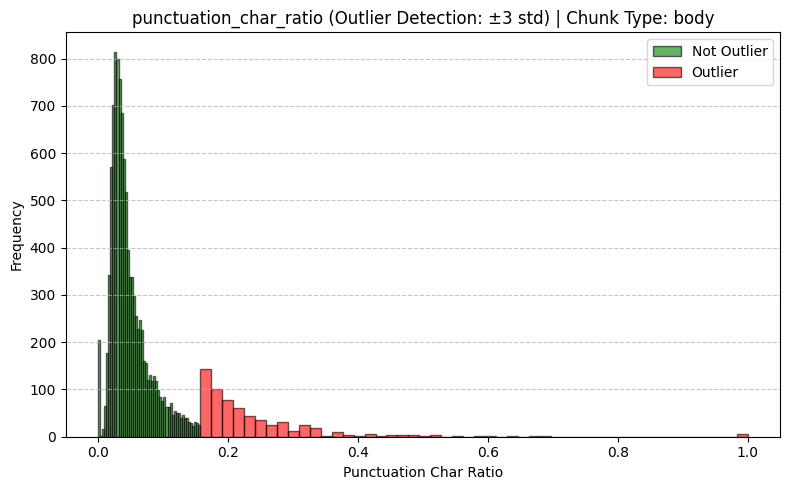

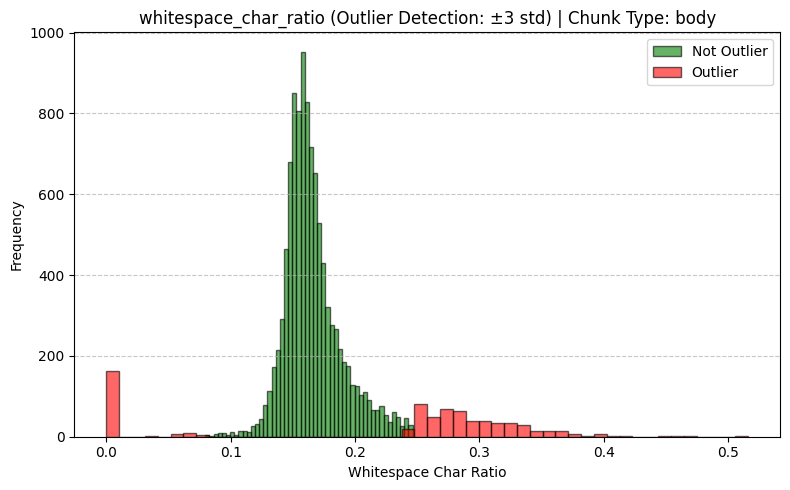

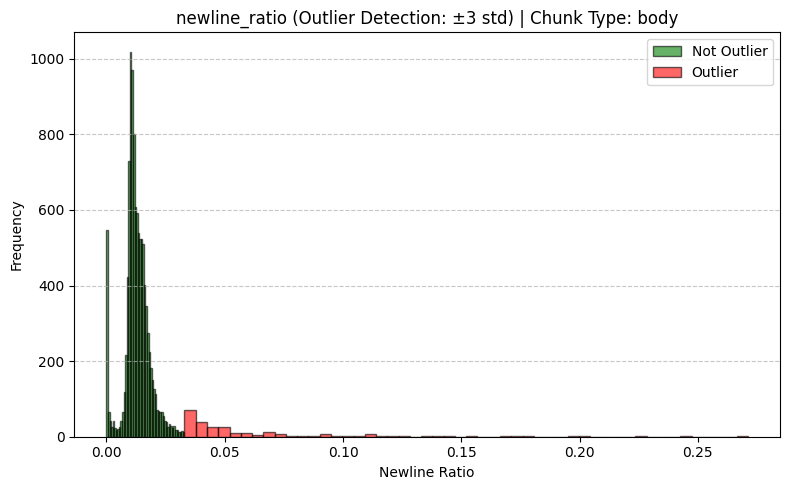

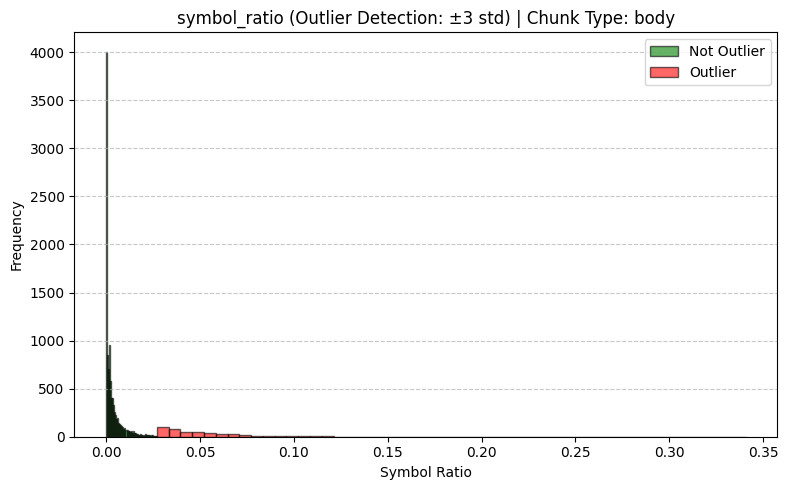

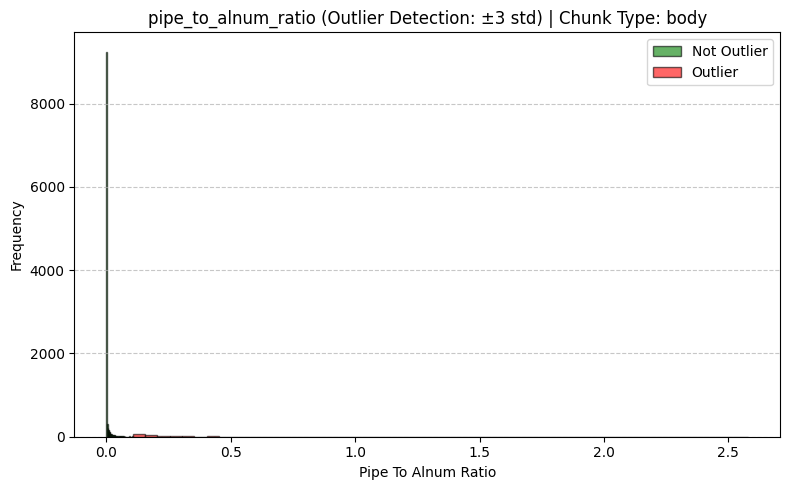

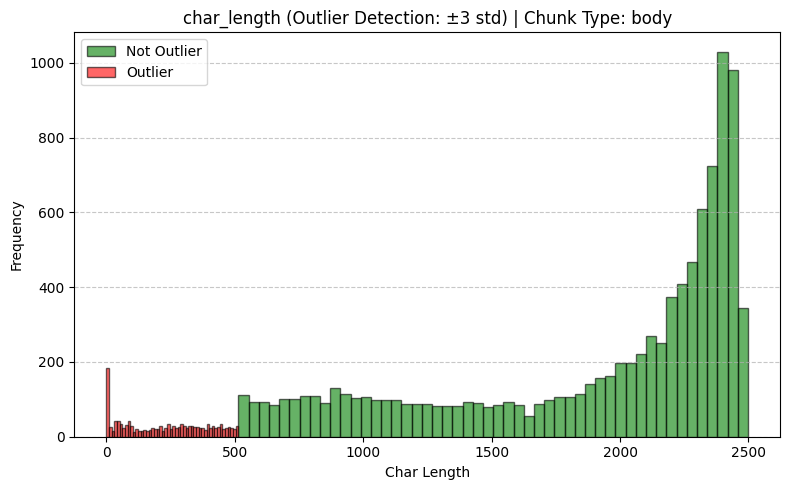

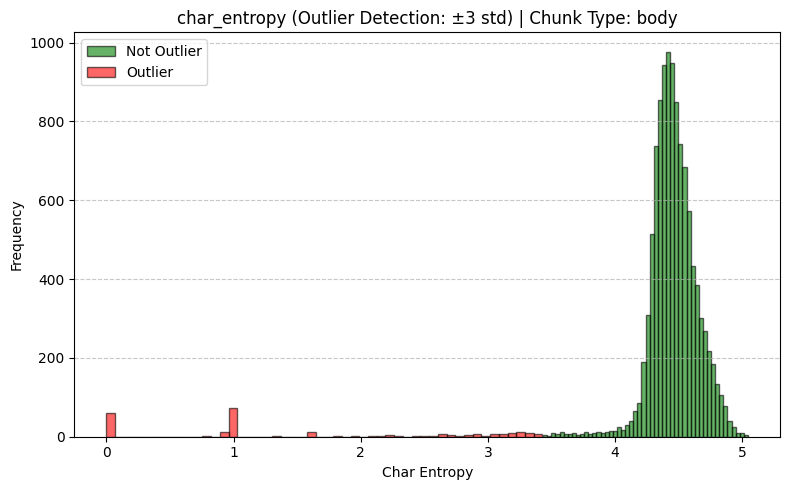

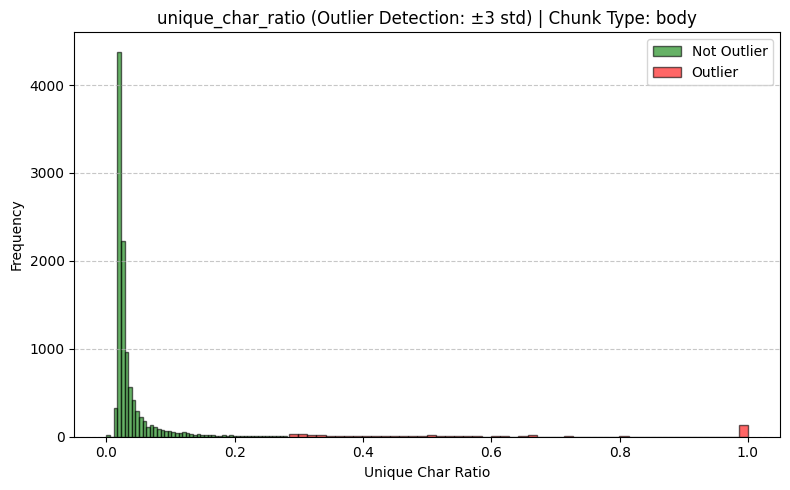

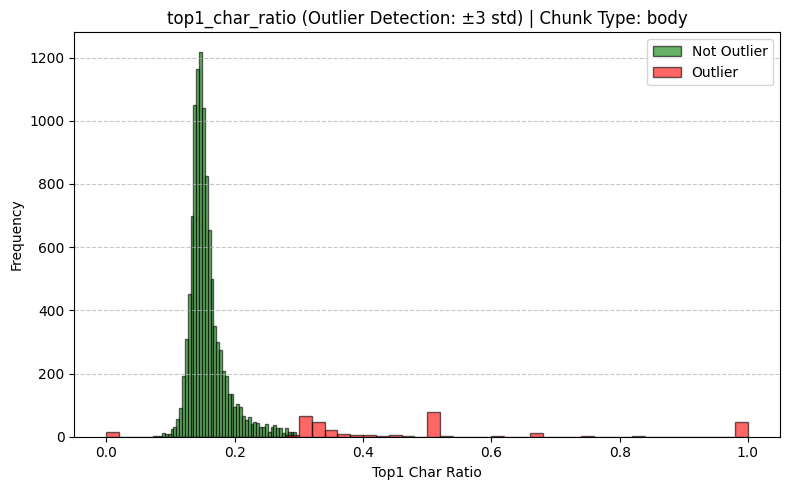

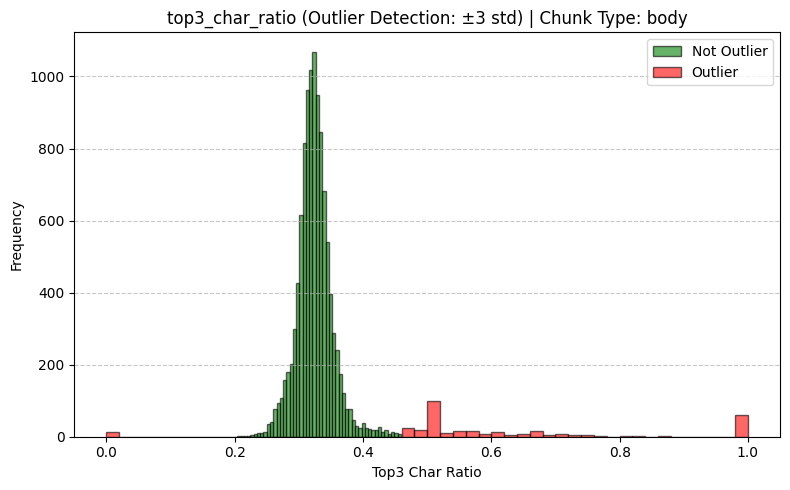

In [29]:
body_character_metrics_summary_df = summarize_char_metrics_from_dataset(local_chunk_dataset, filter_field="chunk_type", filter_value="body")

body_outliers_by_metric = get_outlier_indices_by_metric(
    dataset=local_chunk_dataset,
    summary_df=body_character_metrics_summary_df,
    std_multiplier=2,
    filter_field="chunk_type",
    filter_value="body"
)

# Plot histograms directly from the HF dataset
plot_metric_outlier_histograms_from_hf_dataset(
    hf_dataset=local_chunk_dataset,
    outlier_indices_dict=body_outliers_by_metric,
    metrics_summary=body_character_metrics_summary_df,
    std_multiplier=3,
    chunk_type_filter="body"
)

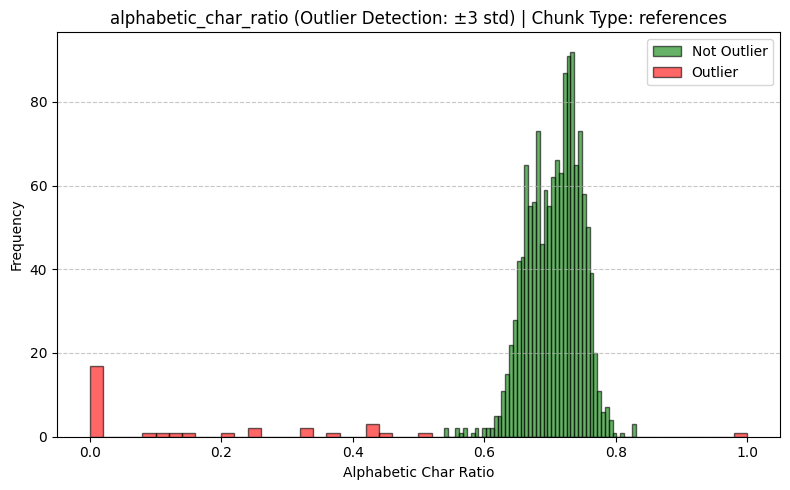

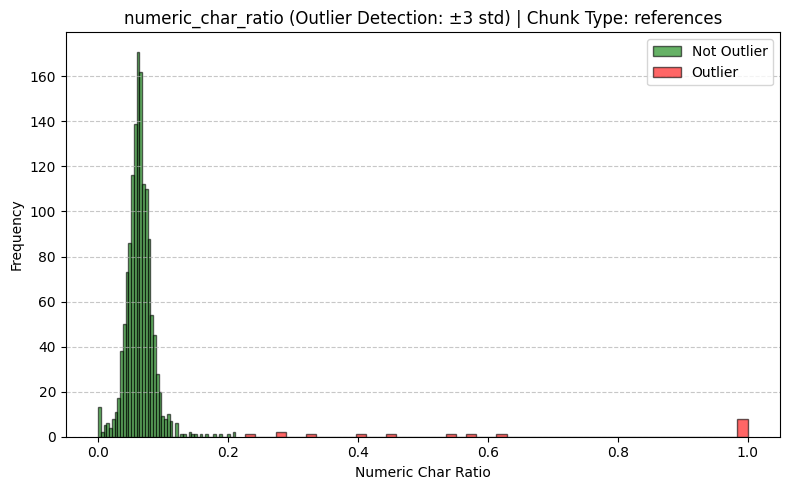

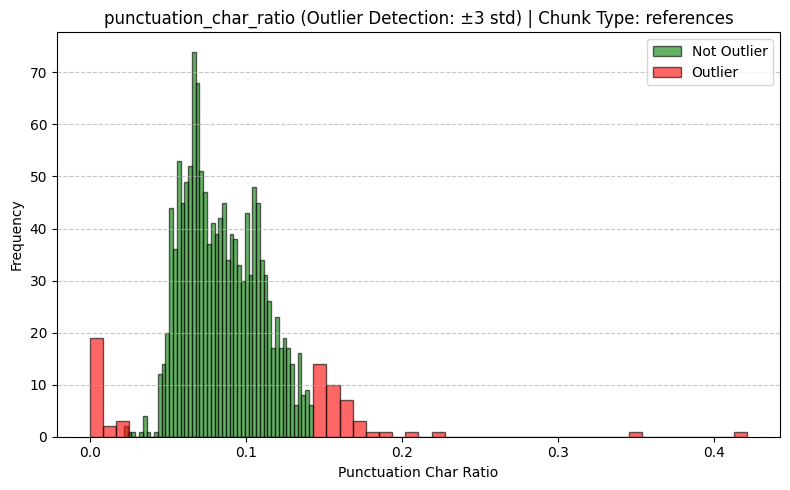

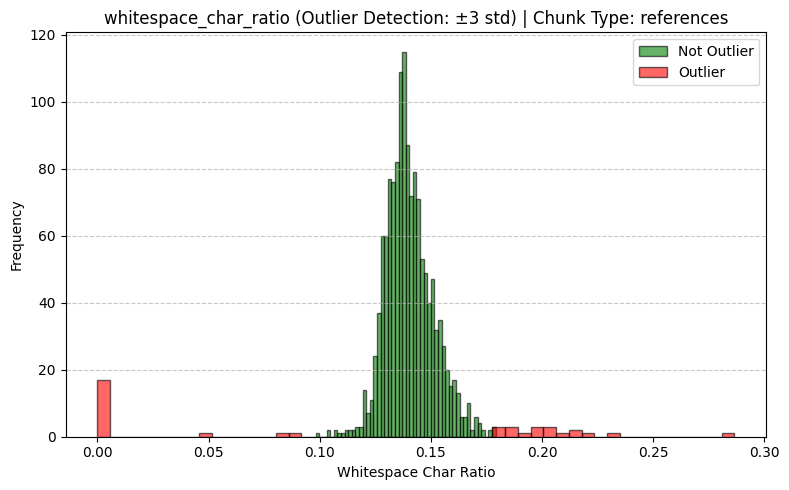

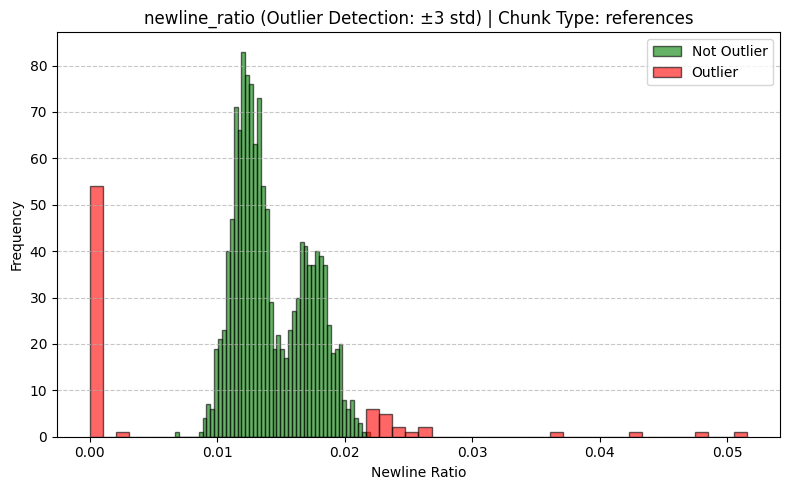

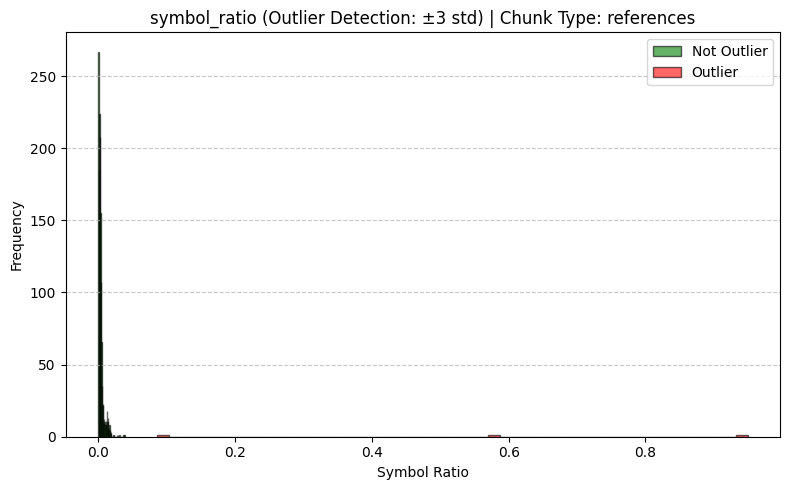

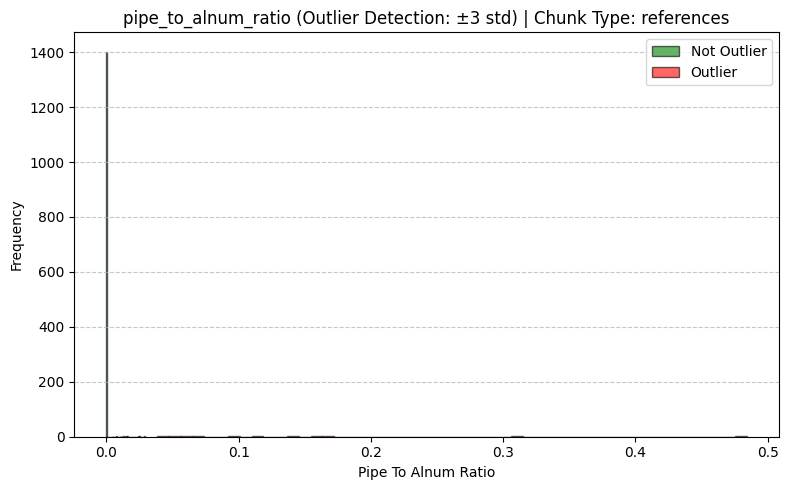

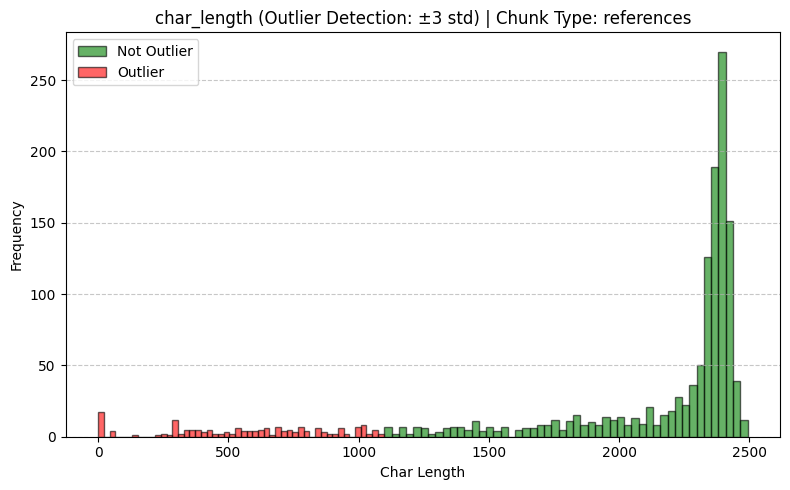

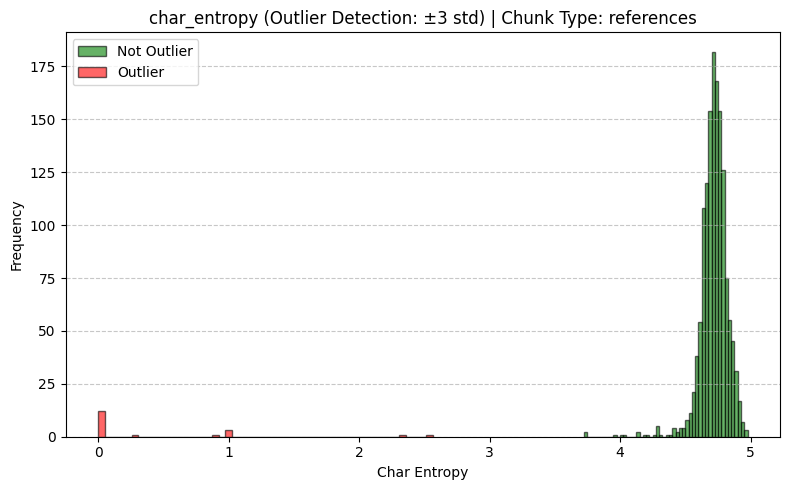

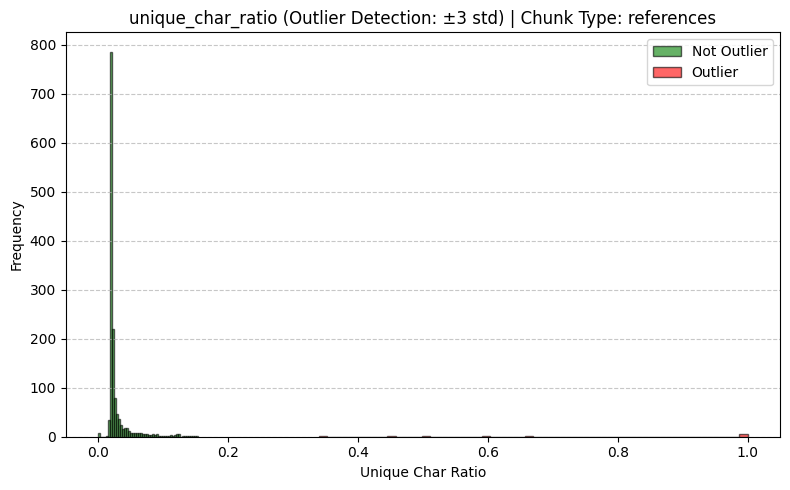

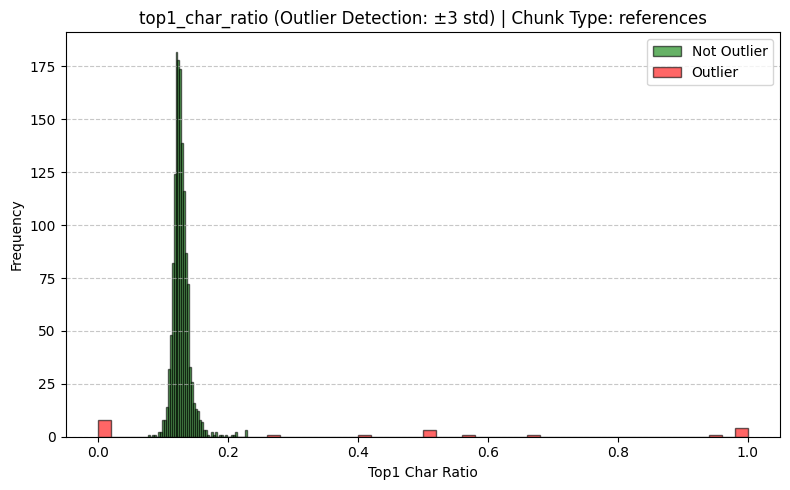

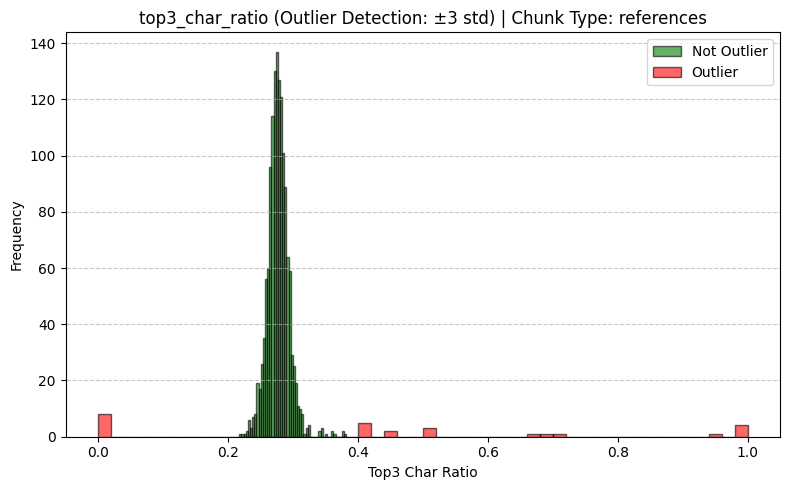

In [30]:
references_character_metrics_summary_df = summarize_char_metrics_from_dataset(local_chunk_dataset, filter_field="chunk_type", filter_value="references")

references_outliers_by_metric = get_outlier_indices_by_metric(
    dataset=local_chunk_dataset,
    summary_df=references_character_metrics_summary_df,
    std_multiplier=2,
    filter_field="chunk_type",
    filter_value="references"
)

# Plot histograms directly from the HF dataset
plot_metric_outlier_histograms_from_hf_dataset(
    hf_dataset=local_chunk_dataset,
    outlier_indices_dict=references_outliers_by_metric,
    metrics_summary=references_character_metrics_summary_df,
    std_multiplier=3,
    chunk_type_filter="references"
)

In [31]:
def print_flagged_plaintext_by_metric_dict(dataset, outlier_indices_dict, max_print=10, metric_filter=None):
    """
    Prints the plaintext of flagged chunks by metric for manual inspection.

    Parameters:
        dataset (Dataset): HuggingFace Dataset.
        outlier_indices_dict (dict): Dictionary {metric: list of outlier indices}.
        max_print (int): Max chunks to display per metric.
    """
    for metric, flagged_indices in outlier_indices_dict.items():

        if (metric not in metric_filter) and (len(metric_filter) > 0):
            continue

        print(f"\n🔍 Metric: {metric}")
        print(f"📌 Showing up to {max_print} flagged chunks of {len(flagged_indices)} total flagged chunks...\n")

        for i, idx in enumerate(flagged_indices[:max_print]):
            chunk = dataset[idx]
            print(f"🔹 ArXiv ID: {chunk['pdf_metadata']['id']}")
            print(f"🔹 Chunk Index: {idx}")
            print(f"📊 {metric}: {chunk.get(metric, 'N/A')}")
            print(f"📄 Chunk Type: {chunk.get('chunk_type', chunk.get('chunk_metadata', {}).get('chunk_type', 'Unknown'))}")
            print(f"📝 Plaintext:\n{chunk['plaintext']}\n")


In [32]:
# In VSCODE you can set this to 1000000 if you want to, its just that if I set it that, when I save the notebook it won't render on github

print_flagged_plaintext_by_metric_dict(
    dataset=local_chunk_dataset,
    outlier_indices_dict=body_outliers_by_metric,
    max_print=10,
    metric_filter='char_entropy'
)


🔍 Metric: char_entropy
📌 Showing up to 10 flagged chunks of 256 total flagged chunks...

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 20
📊 char_entropy: 3.2359263506290326
📄 Chunk Type: body
📝 Plaintext:
1 Introduction

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 23
📊 char_entropy: 0.0
📄 Chunk Type: body
📝 Plaintext:


🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 28
📊 char_entropy: 3.240223928941852
📄 Chunk Type: body
📝 Plaintext:
E w [f (w)] =
n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 46
📊 char_entropy: -0.0
📄 Chunk Type: body
📝 Plaintext:
6

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 50
📊 char_entropy: 2.9874687506009634
📄 Chunk Type: body
📝 Plaintext:
E [(] w [i][)] [[][f] [(][w][)] =]
n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 55
📊 char_entropy: 3.3086949695628425
📄 Chunk Type: body
📝 Plaintext:
C v L(n) = − [1] n
n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 61
📊 char_entropy: 3.240223928941852
📄 Chunk Type: body
📝 Plaintext:
F (α) = [1] n
n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 71
📊 char_entropy: 3.428070140478873
📄 C

# Conclusions so far (ONLY PERTAINING TO FIELDS LISTED BELOW, NOT ALL FIELDS HAVE BEEN TESTED)

## Good Potential Filters (for body chunks, aka the ones we actually use):

Others need to be inspected by manually reviewing chunk results (basically).


## Obtained via testing this function

- ### pipe_to_alnum_ratio = '|' / count(alphanumeric_characters) : character frequency based filter (either total pct or against alphanumeric ratio in pipe_to_alnum_ratio)

# Not Good

- ### whitespace_char_ratio : it seems like the body chunks this would work on are all very short and will get eliminated in the min characters floor and min tokens floor steps anyway

- ### symbol_ratio : there are potentially useful bits of information in symbols in this corpus (in the form of equations); that being said specific symbols could works

## Query 1:
well, I am basically filtering out references and title chunks from my knowledge base. mostly what I'm concerned with is filtering out body chunks that should be re-assigned to one of those categories. I actually have near perfect title detection (at least so far, 365/365 titles have been detected), so my main concern is detecting body chunks that are comprised of mostly if not all references (so, mislabeled body chunks that should be labeled references). after that, my main concern is actually reducing high noise, low entropy, low value / non-sensical / not long enough (char /token length) chunks.

## Response 1:
```markdown
That's a super clear and actionable objective — and you're already very close to building a *high-quality, lean knowledge base*. Let's break this down based on your **two major concerns**, and tailor the next metric development steps specifically for **body chunk filtering**:

---

## 🎯 Goal 1: Detect Misclassified Reference Chunks (labeled as "body")

### ✅ Key Signals of Reference Chunks

1. **Brackets & Citations**:
   - High frequency of patterns like `[...]`, `(Author, Year)`, `[1]`, etc.
   - Metric: `citation_bracket_ratio` — ratio of brackets (`[` or `]`) to total characters or tokens.

2. **High punctuation / low alphabetic ratio**:
   - References tend to have:
     - High punctuation
     - Lots of numerals
     - Short "bursty" words
     - Low `alphabetic_char_ratio`

3. **Author-ish terms**:
   - Count of `et al`, `Proc`, `vol`, `IEEE`, `Springer`, etc.
   - Metric: `reference_token_hits` — count of known reference-style keywords.

4. **Reference Regex Matching**:
   - You can re-use your strong header-detection regex to build **line-level detection** (e.g., look for `[AuthorYear]` patterns line-by-line).
   - Metric: `reference_line_ratio`: proportion of lines that match reference-like regexes.

---

## 🎯 Goal 2: Filter Noisy / Low-Value Chunks (non-sensical or malformed)

### ✅ Key Signals of Low-Quality Body Chunks

1. **Character Entropy**:
   - Very low entropy = mostly the same few characters.
   - Metric: `char_entropy` (Shannon entropy over character distribution)

2. **Unique Character Ratios**:
   - You mentioned this — great.
   - Add: `unique_char_ratio`, `top1_char_ratio`, `top3_char_ratio`

3. **Excessive Symbol Usage**:
   - Too many pipes, equal signs, underscores, etc.
   - Metric: `pipe_to_alnum_ratio`, `symbol_density`

4. **Token Entropy** *(optional but strong)*:
   - Low token entropy = repeated phrases or words, often non-meaningful.
   - Can compute if you tokenize with `nltk.word_tokenize`.

5. **Token to Sentence Ratio**:
   - Low token/sentence ratio suggests fragmented or broken chunks.

6. **Low Length (Char / Token)**:
   - Already in your plan, great.
   - Metric: `char_length`, `token_length`

---

## 🧠 Strategy for Filtering Pipeline

You can now think about filtering in *two phases*:

### 🔹 Phase 1: Reassign "References"
Apply a lightweight classifier (rule-based):
```python
if (
    citation_bracket_ratio > 0.05 or
    reference_token_hits > 3 or
    punctuation_char_ratio > 0.15
):
    chunk_type = "references"
```

Then **relabel** those chunks and exclude them from your knowledge base.

### 🔹 Phase 2: Score Quality of Remaining Body Chunks
Create a composite `quality_score` or assign flags per metric (like you're doing now).

Example filtering thresholds:
```python
char_length >= 1000
top1_char_ratio < 0.4
unique_char_ratio > 0.1
char_entropy > 2.5
pipe_to_alnum_ratio < 0.2
```

Log all **flagged body chunks** and manually sample to refine thresholds.

---

Would you like help drafting the actual metric function implementations for:
- `citation_bracket_ratio`
- `reference_token_hits`
- `char_entropy`
- `unique_char_ratio` and `topN_char_ratio`

so you can `.map()` them across your dataset and visualize outliers?
```


## Query 2:

Ok so can you break the metrics and methods from the goals that you defined into sections by what level of filtering they correspond to? (i.e., character filtering, token filtering, length filtering, etc.)

## Response 2:

```markdown

Absolutely — here’s a clean breakdown of the **metrics and methods** categorized by filtering **levels**, each aligned to the **goals** you mentioned:  

---

## 🎯 GOAL 1: Detect *Misclassified Reference* Chunks  
→ Body chunks that are actually reference sections.

### 🧱 Character-Level Filtering
| Metric | Description | Rationale |
|--------|-------------|-----------|
| `citation_bracket_ratio` | Ratio of `[` or `]` characters to total chars | Reference formats like `[1]`, `[Smith et al.]` |
| `punctuation_char_ratio` | Already computed | References often contain dense punctuation |
| `numeric_char_ratio` | Already computed | Citations, years, volume numbers |
| `pipe_to_alnum_ratio` | Already computed | Markdown table overflow common in reference blocks |
| `symbol_ratio` | Already computed | Extra formatting, edge cases |

---

### 🔤 Token-Level Filtering  
| Metric | Description | Rationale |
|--------|-------------|-----------|
| `reference_token_hits` | Count of tokens like `et al`, `vol.`, `proc.`, `IEEE`, etc. | Common indicators of reference lines |
| `token_entropy` | Entropy over token distribution | Low variation = repeated citation templates |
| `num_reference_like_lines` | Number of lines matching reference-style regex | Pattern-based: detect `[AuthorYear]` or `[1]` |

---

### 📏 Length & Structure  
| Metric | Description | Rationale |
|--------|-------------|-----------|
| `line_count` | Total number of lines | References are often many short lines |
| `avg_line_length` | Mean characters per line | Reference lines are usually short |
| `sentence_count` | Number of detected sentences (optional) | Reference blocks often have zero or very few full sentences |

---

## 🎯 GOAL 2: Filter *Low-Information / Noisy Chunks*  
→ Chunks that are malformed, templated, or not human-readable.

### 🧱 Character-Level Filtering  
| Metric | Description | Rationale |
|--------|-------------|-----------|
| `char_entropy` | Entropy of character distribution | Low = repetitive junk (e.g., `|||||||||`) |
| `unique_char_ratio` | Unique chars / total chars | Low = poor diversity (e.g., just `=`, `|`, `-`) |
| `top1_char_ratio`, `top3_char_ratio` | Proportion of most frequent chars | High = dominance by 1–3 chars |
| `pipe_to_alnum_ratio` | Already computed | Pipe-heavy table artifacts or formatting noise |
| `symbol_ratio`, `whitespace_char_ratio` | Already computed | Detect overly padded or malformed content |

---

### 🔤 Token-Level Filtering  
| Metric | Description | Rationale |
|--------|-------------|-----------|
| `stopword_ratio` | Already computed | Very low = not real language |
| `token_entropy` | Optional | Low entropy indicates copy/paste or templated junk |
| `nltk_pos_distribution` | Optional | Odd POS distributions can flag tables/code |

---

### 📏 Length-Based Filtering  
| Metric | Description | Rationale |
|--------|-------------|-----------|
| `char_length` | Already used | Cut off short fragments (<1000 chars) |
| `token_length` | (Use tokenizer) | For embedding alignment (~500 tokens ideal) |
| `token_to_sentence_ratio` | Optional | Too low = fragmented text |
| `avg_token_length` | Optional | Can help detect malformed tokens or table artifacts |

---

## 🔄 Bonus: *Chunk Reassignment Heuristics*  
If a chunk violates certain thresholds (e.g., high `reference_token_hits`, high `citation_bracket_ratio`), consider **reassigning** its `chunk_type` to `"references"` instead of outright dropping it.

---

Would you like code stubs for all of these metric functions, categorized and wrapped as `.map()`-ready functions for `datasets.Dataset`?

```

# Goal: Reference Section Detection

Here is a perfect example of one of the main, most difficult things to try to parse out that must be done:



```
🔹 ArXiv ID: 1301.7363
🔹 Chunk Index: 558
📄 Chunk Type: body
📝 Plaintext:
ditions, Bayesian networks with decision trees at each
node and correlation methods outperform Bayesian
clustering and vector similarity methods. Between cor
relation and Bayesian networks, the preferred method
depends on the nature of the dataset, nature of the ap
plication ( ranked or one-by-one presentation ), and the
availability of votes with which to make predictions.
We see that when there are relatively few votes, corre
lation and Bayesian networks have less of an advantage
over the other techniques.
Other considerations include the size of database,
speed of predictions, and learning time. Bayesian net
works are typically have smaller memory requirements
and allow for faster predictions than a memory-based  
52 Breese, Heckerman, and Kadie
technique such as correlation. However, the Bayesian
methods examined here require a learning phase that
can take up to several hours and results in a lag before
changed behavior is reflected in recommendations.
We plan to make the MS Web data used in this study
available to learning community through the Irvine
repository. As noted, the EachMovie data is currently
available. We hope that the availability of this data
coupled with discussion spurred by this paper will re
sult in additional examination and improvement of col
laborative filtering algorithms.
Acknowledgements
Datasets for this paper were generously provided by
Digital Equipment Corporation (EachMovie), Neilsen
Media Research (Neilsen), and Microsoft Corporation
(MS Web). Max Chickering, David Hovel, and Robert
Rounthwaite contributed to the programming of the
algorithms that were used in this study. We also thank
Max Chickering, Eric Horvitz, and Chris Meek for use
ful discussions. John Riedl also provided useful com
ments.
References
[Breese et al., 1998] Breese, J., Heckerman, D., and
Kadie, C. (May, 1998). An experimental compar
ison of collaborative filtering methods. Technical
Report MSR-TR-98-12, Microsoft Research, Red
mond, WA.
[Cheeseman and Stutz, 1995] Cheeseman, P.
and Stutz, J. (1995). Bayesian classification (Auto
Class): Theory and results. In Fayyad, U., Piatesky
Shapiro, G., Smyth, P., and Uthurusamy, R., ed
itors, Advances in Know ledge Discovery and Data
Mining, pages 153-180. AAAI Press, Menlo Park,
CA.
[Chickering and Heckerman, 1997] Chickering, D. and
Heckerman, D. (1997). Efficient approximations for
the marginal likelihood of Bayesian networks with

🔹 ArXiv ID: 1301.7363
🔹 Chunk Index: 559
📄 Chunk Type: body
📝 Plaintext:
Mining, pages 153-180. AAAI Press, Menlo Park,
CA.
[Chickering and Heckerman, 1997] Chickering, D. and
Heckerman, D. (1997). Efficient approximations for
the marginal likelihood of Bayesian networks with
hidden variables. Machine Learning, 29:181-212.
[Chickering et al., 1997] Chickering, D., Heckerman,
D., and Meek, C. (1997). A Bayesian approach
to learning Bayesian networks with local structure.
In Proceedings of Thirteenth Conference on Un
certainty in Artificial Intelligence, Providence, RI.
Morgan Kaufmann.
[Dempster et al., 1977] Dempster, A., Laird, N., and
Rubin, D. (1977). Maximum likelihood from incom
plete data via the EM algorithm. Journal of the
Royal Statistical Society, B 39:1-38.
[L.Terveen et al., 1997] L.Terveen, Hill, W., Amenta,
B., McDconald, D., and Creter, J. (1997).
PHOAKS: A system for sharing recommendations.
Communications of the ACM, 40(3):59-62.
[McClave and Dietrich, 1988] McClave, J. T. and Di
etrich, F. H. (1988). Statistics. Dellen Publishing
Company, San Francisco, fourth edition.
[Miller et al., 1997] Miller, B., Riedl, J., and Konstan,
J. (1997). Experiences with GroupLens: Making
Usenet useful again. In Proceeding of the USENIX
1997 Annual Technical Conference, pages 219-231,
Anaheim, CA.
[Resnick et al., 1994]
Resnick, P., Iacovou, N., Suchak, M., Bergstrom,
P., and Riedl, J. (1994). Grouplens: An open ar
chitecture for collaborative filtering of netnews. In
Proceedings of the ACM 1994 Conference on Com
puter Supported Cooperative Work, pages 175-186,
New York. ACM.
[Resnick and Varian, 1997] Resnick, P. and Varian, H.
(1997). Recommender systems. Communications of
the ACM, 40(3):56-58.  
[Salton and McGill, 1983] Salton, G. and McGill, M.
(1983). Introduction to Modern Information Re
trieval. McGraw-Hill, New York.
[Thiesson et al., 1997] Thiesson, B., Meek, C., Chick
ering, D., and Heckerman, D. (December, 1997).
Learning mixtures of DAG models. Technical
Report MSR-TR-97-30, Microsoft Research, Red
mond, WA.
```

As you can see, the detected header is listed as chunk type for the second subsequent chunk (559) despite the fact that it is obviously a reference chunk.

This happens because the `References` header is not detected during our chunking process by the header splitter.

This example perfectly highlights the necessity of more advanced detection of references sections.

Another Example is this (but likely on a much smaller scale than the references problem)

```
🔹 ArXiv ID: 1308.0850
🔹 Chunk Index: 704
📄 Chunk Type: body
📝 Plaintext:
Acknowledgements
Thanks to Yichuan Tang, Ilya Sutskever, Navdeep Jaitly, Geoffrey Hinton and
other colleagues at the University of Toronto for numerous useful comments
and suggestions. This work was supported by a Global Scholarship from the
Canadian Institute for Advanced Research.
```

Obviously, this is a useless chunk to us, and we were able to actually parse the header here. `Achknowledgements` sections are probably common enough that excluding them makes sense.

# Goal: Abnormal Body Chunk Detection

We want to detect refrences or body chunks that are not normal. As you will see below, in this example, what ended up happening is that

for some of these, the lower level headers actually contain the text information. There may be a simple fix here, but one should be thought of if it turns out to be a re-occuring problem.




```

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 20
📄 Chunk Type: body
📝 Plaintext:
1 Introduction

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 25
📄 Chunk Type: body
📝 Plaintext:
2 Bayes Learning Theory
In this section, we summarize Bayes learning theory for singular learning machines. The results written in this section are well known and the fundamental basis of this paper. Table 1 shows variables, names, and equation numbers in this paper.

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 26
📄 Chunk Type: body
📝 Plaintext:
2.1 Framework of Bayes Learning
Firstly, we explain the framework of Bayes learning. Let q(x) be a probability density function on N dimensional real Euclidean space R [N] . The training samples and the testing sample are respectively denoted by random variables X 1, X 2, ..., X n and X, which are independently subject to the same probability distribution as q(x)dx. The probability distribution q(x)dx is sometimes called the true distribution. A statistical model or a learning machine is defined by a probability density function p(x|w) of x ∈ R [N] for a given parameter w ∈ W ⊂ R [d], where W is a set of 3

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 27
📄 Chunk Type: body
📝 Plaintext:
all parameters. In Bayes estimation, we prepare a probability density function ϕ(w) on W . Although ϕ(w) is called a prior distribution, it does not necessary represent an a priori knowledge of the parameter, in general. For a given function f (w) on W, its expectation value with respect to the pos- terior distribution is defined by

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 29
📄 Chunk Type: body
📝 Plaintext:
f (w) � p(X i |w) [β] ϕ(w)dw �
i=1
n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 31
📄 Chunk Type: body
📝 Plaintext:
where 0 < β < ∞ is the inverse temperature. The case β = 1 is most important because it corresponds to the conventional Bayes estimation. The Bayes predictive distribution is defined by p [∗] (x) ≡ E w [p(x|w)]. In Bayes learning theory, the following random variables are important. The Bayes generalization loss B g L(n) and the Bayes training loss B t L(n) are respectively de- fined by B g L(n) = −E X [log p [∗] (X)], (2)
n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 35
📄 Chunk Type: body
📝 Plaintext:
which shows fluctuation of the posterior distribution. In previous papers [Watanabe 09, Watanabe 10a, Watanabe 10b], we defined the widely applicable information crite- rion WAIC(n) ≡ B t L(n) + [β] (5) n [V][ (][n][)][,] and proved that E[B g L(n)] = E[WAIC(n)] + o( [1] n [)][,] where E[ ] shows the expectation value over the sets of training samples.

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 37
📄 Chunk Type: body
📝 Plaintext:
The log loss function L(w) and the entropy S of the true distribution are respec- tively defined by L(w) = −E X [log p(X|w)], (6) S = −E X [log q(X)]. (7) Then L(w) = S + D(q||p w ), where D(q||p w ) is Kullback-Leibler distance defined by D(q||p w ) = q(x) log [q][(][x][)] � p(x|w) [dx.] Then D(q||p w ) ≥ 0, hence L(w) ≥ S. Moreover, L(w) = S if and only if p(x|w) = q(x). In this paper, we assume that there exists a parameter w 0 ∈ W which minimizes L(w), L(w 0 ) = min w∈W [L][(][w][)][.] Note that such w 0 is not unique in general, because the map w �→ p(x|w) is not one-to-one in general in singular learning machines. We also assume that, for an arbitrary w that satisfies L(w) = L(w 0 ), p(x|w) is the same probability density function. Let p 0 (x) be such a unique probability density function. In general, the set W 0 = {w ∈ W ; p(x|w) = p 0 (x)} is not a set of single element but an analytic set or an algebraic set with singularities. For simple notations, the minimum log loss L 0 and the empirical log loss L n are respectively defined by L 0 = −E X [log p 0 (X)], (8)
n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 38
📄 Chunk Type: body
📝 Plaintext:
L n = −n [1] � log p 0 (X i ). (9)
i=1

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 39
📄 Chunk Type: body
📝 Plaintext:
By using these values, Bayes generalization error B g (n) and Bayes training error B t (n) are respectively defined by B g (n) = B g L(n) − L 0, (10) B t (n) = B t L(n) − L n . (11) In general, both B g (n) and B t (n) converge to zero in probability, when n →∞. Let us define a log density ratio function, f (x, w) = log [p] [0] [(][x][)] p(x|w) [,] which is equivalent to p(x|w) = p 0 (x) exp(−f (x, w)). 5

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 42
📄 Chunk Type: body
📝 Plaintext:
V (n) = ��E w [f (X i, w) [2] ] − E w [f (X i, w) [2] ]�. (14)
i=1

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 43
📄 Chunk Type: body
📝 Plaintext:
Therefore, the problem of statistical learning is characterized by the function f (x, w). Definition. (1) If q(x) = p 0 (x), then q(x) is said to be realizable by p(x|w). If otherwise, then it is said to be unrealizable. (2) If the set W 0 consists of a single point w 0 and if the Hessian matrix ∇∇L(w 0 ) is strictly positive definite, then q(x) is said to be regular for p(x|w). If otherwise, then it is said to be singular for p(x|w). Bayes learning theory was studied in a realizable and regular case [Schwarz 78, Levin et al. 90, Aamari 93]. The concept WAIC was found in a realizable and sin- gular case [Watanabe 01a, Watanabe 09, Watanabe 10a] and an unrealizable and regular case [Watanabe 10b]. It was generalized for an unrealizable and singular case [Watanabe 10d].

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 47
📄 Chunk Type: body
📝 Plaintext:
The set W ǫ is defined by W ǫ = {w ∈ W ; K(w) ≤ ǫ}. It is assumed that there exist constants ǫ, c > 0 such that (∀w ∈ W ǫ ) E X [f (X, w)] ≥ c E X [f (X, w) [2] ]. (15) In order to study the cross validation in singular learning machines, we need singular learning theory. In the previous papers, we obtained the following lemma. Lemma 1. Assume that the above assumptions (1),(2),(3), and (4) are satisfied. Then the followings hold. (1) Three random variables nB g (n), nB t (n), and V (n) converge in law, when n tends to infinity. Also their expectation values converge. (2) For k = 1, 2, 3, 4, we define M k (n) ≡ E[E w [E X [| f (X, w)| [k] sup exp(σf (X, w))]]]. (16)
|σ|≤1+β

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 48
📄 Chunk Type: body
📝 Plaintext:
Then limsup n→∞ n [k][/][2] M k (n) < ∞. (17) � � (3) The expectation value of the Bayes generalization loss is asymptotically equal to the widely applicable information criterion, E[B g L(n)] = E[WAIC(n)] + o( [1] (18) n [)][.] (Proof) In the case when q(x) is realizable by and singular for p(x|w), this lemma was proved in [Watanabe 10a]. The proof of Lemma 1 (1) is given in Theorem 1 of [Watanabe 10a]. The result in Lemma 1 (2) can be proved by just the same way as Lemma 6 in [Watanabe 10a]. The proof of Lemma 1 (3) is given in Theorem 2 and discussion of [Watanabe 10a]. In the case when q(x) is regular for and unrealizable by p(x|w), this lemma was proved in [Watanabe 10b]. These results were generalized in [Watanabe 10d]. (Q.E.D.) Remark. In ordinary learning machines, if the true distirbution is regular for or realizable by a learning machine, then the assumptions (1)-(4) are satisfied, result- ing that the results of this paper hold. If the true distribution is singular for and unrealizable by a learning machine, in some cases the assumptions (1)-(4) are satis- fied but in other cases not. If the true distribution is singular for and unrealizable by a learning machine and if the assumptions (1)-(4) are not satisfied, then the Bayes generalization and training errors may have the other asymptotic behaviors [Watanabe 10d]. 7

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 49
📄 Chunk Type: body
📝 Plaintext:
3 Bayes Cross Validation
In this section, we introduce the cross validation in Bayes learning. For an arbitrary function f (w), the expectation value E w [(][i][)] [[][f] [(][w][)] using the pos-] terior distribution leaving X i out is defined by

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 50
📄 Chunk Type: body
📝 Plaintext:
E [(] w [i][)] [[][f] [(][w][)] =]
n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 51
📄 Chunk Type: body
📝 Plaintext:
f (w) � p(X j |w) [β] ϕ(w)dw � j≠ i
n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 52
📄 Chunk Type: body
📝 Plaintext:
� p(X j |w) [β] ϕ(w)dw � j≠ i
, (19)
n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 53
📄 Chunk Type: body
📝 Plaintext:
where � shows the product for j = 1, 2, 3, .., n which does not include j = i. The
j≠ i

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 58
📄 Chunk Type: body
📝 Plaintext:
Remark. In practical applications, the Bayes generalization loss B g L(n) indicates the accuracy of Bayes estimation. However, in order to calculate B g L(n), we need the expectation value over the testing sample taken from the unknown true distri- bution, resulting that we can not directly obtain B g L(n) in practical applications. On the other hand, both the cross validation loss C v L(n) and the widely applica- ble information criterion WAIC(n) can be calculated using only training samples. Therefore, the cross validation loss and the widely applicable information criterion can be used for model selection and hyperparameter optimization. This is the rea- son why comparison of these random variables is an important issue in statistical learning theory.

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 59
📄 Chunk Type: body
📝 Plaintext:
4 Main Results
In this section, main results of this paper are explained.

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 62
📄 Chunk Type: body
📝 Plaintext:
� log E w [p(X i |w) [α] ]. (21)
i=1

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 63
📄 Chunk Type: body
📝 Plaintext:
The kth order functional cumulant Y k (n) (k = 1, 2, 3, 4) is defined by

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 64
📄 Chunk Type: body
📝 Plaintext:
Then, by definition, For simple notation, we use

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 65
📄 Chunk Type: body
📝 Plaintext:
Y k (n) = [d] [k] [F] (22) dα [k] [ (0)][.] F (0) = 0, F (1) = −B t L(n).

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 66
📄 Chunk Type: body
📝 Plaintext:
ℓ k (X i ) = E w [(log p(X i |w)) [k] ] (k = 1, 2, 3, 4). 9

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 67
📄 Chunk Type: body
📝 Plaintext:
Lemma 2. The followings hold, 1 n Y 1 (n) = n � ℓ 1 (X i ), (23)
i=1

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 68
📄 Chunk Type: body
📝 Plaintext:
1 n Y 2 (n) = n ��ℓ 2 (X i ) − ℓ 1 (X i ) [2] [�], (24)
i=1

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 70
📄 Chunk Type: body
📝 Plaintext:
1 n Y 4 (n) = n ��ℓ 4 (X i ) − 4ℓ 3 (X i )ℓ 1 (X i ) − 3ℓ 2 (X i ) [2] (26)
i=1

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 71
📄 Chunk Type: body
📝 Plaintext:
+12ℓ 2 (X i )ℓ 1 (X i ) [2] − 6ℓ 1 (X i ) [4] [�] . (27)

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 72
📄 Chunk Type: body
📝 Plaintext:
Moreover, In other words,

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 74
📄 Chunk Type: body
📝 Plaintext:
(Proof) Firstly, we prove eqs.(23)-(27). Let us define g i (α) = E w [p(X i |w) [α] ]. Then g i (0) = 1, g i [(][k][)] [(0) =][ ℓ] [k] [(][X] [i] [)] (k = 1, 2, 3, 4), and
n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 75
📄 Chunk Type: body
📝 Plaintext:
F (α) = n [1] � log g i (α).
i=1

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 76
📄 Chunk Type: body
📝 Plaintext:
For arbitrary natural number k,

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 77
📄 Chunk Type: body
📝 Plaintext:
g i (α) (k) � g i (α)

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 79
📄 Chunk Type: body
📝 Plaintext:
g i (α) �� g i (α)

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 80
📄 Chunk Type: body
📝 Plaintext:
. �

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 81
📄 Chunk Type: body
📝 Plaintext:
By using this relation recursively, eqs.(23)-(27) are derived. Secondly, we show eq.(28). The random variables Y k (n) (k = 2, 3, 4) are invariant under the transform, log p(X i |w) �→ log p(X i |w) + c(X i ), (29) for arbitrary c(X i ). In particular, by choosing c(X i ) = − log p 0 (X i ),@we can show that Y k (n) (k = 2, 3, 4) are invariant by replacing log p(X i |w) �→ f (X i, w). 10

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 82
📄 Chunk Type: body
📝 Plaintext:
Then by using eq.(17), eq.(28) is obtained. (Q.E.D.) Note that Y k (n) (k = 1, 2, 3, 4) can be calculated using only training samples and a statistical model, without any information about the true distribution q(x). More- over, by definition, nY 2 (n) = V (n). By using eq.(29) with c(X i ) = −E w [log p(X i |w)] and by using the normalized func- tion defined by ℓ [∗] k [(][X] [i] [) =][ E] [w] [[(log][ p][(][X] [i] [|][w][)][ −] [c][(][X] [i] [))] [k] []][,] It follows that

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 83
📄 Chunk Type: body
📝 Plaintext:
1 Y 2 (n) = n 1 Y 3 (n) = n 1 Y 4 (n) = n
n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 86
📄 Chunk Type: body
📝 Plaintext:
��ℓ [∗] 4 [(][X] [i] [)][ −] [3][ℓ] [∗] 2 [(][X] [i] [)] [2] [�] .
i=1

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 88
📄 Chunk Type: body
📝 Plaintext:
4.2 Bayes Cross Validation and Widely Applicable Informa- tion Criterion
We show the asymptotic equivalence of the cross validation loss C v L(n) and the widely applicable information criterion WAIC(n). Theorem 1. For arbitrary 0 < β < ∞, the cross validation loss C v L(n) and the widely applicable information criterion WAIC(n) are respectively given by C v L(n) = −Y 1 (n) + 2β − 1 Y 2 (n) � 2 �
2

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 89
📄 Chunk Type: body
📝 Plaintext:
− 3β − 3β + 1 Y 3 (n) + O p ( [1] � 6 � n [2] [)][,] WAIC(n) = −Y 1 (n) + 2β − 1 Y 2 (n) � 2 � − [1] 6 [Y] [3] [(][n][) +][ O] [p] [( 1] n [2] [)][.] (Proof) Firstly, we study C v L(n). From the definition of E w [ ] and E w [(][i][)] [[] ], for arbitrary function f (w), E [(] w [i][)] [[][f] [(][w][)] =][ E] [w] [[][f] [(][w][)][p][(][X] [i] [|][w][)] [−][β] [ ]] . (30) E w [p(X i |w) [−][β] ] 11

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 90
📄 Chunk Type: body
📝 Plaintext:
Therefore, by the definition of the cross validation loss, eq.(20),

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 91
📄 Chunk Type: body
📝 Plaintext:
C v L(n) = − [1] n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 92
📄 Chunk Type: body
📝 Plaintext:
� i=1n log [E] E [w] w [[] [ [ p] p [(] ( [X] X [i] i [|] | [w] w [)] ) [1][−][−][β][β] [ ]] ] [.]

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 93
📄 Chunk Type: body
📝 Plaintext:
By using the generating function of functional cumulants F (α), C v L(n) = F (−β) − F (1 − β). Then by using Lemma 1 (2) for each k = 2, 3, 4, there exists a constant C k > 0 such that |F [(][k][)] (α)| ≤ C k M k (n) (|α| < 1 + β), where C 1 = 1, C 2 = 2, C 3 = 6, C 4 = 26. Therefore, |F [(][k][)] (α)| = O p ( [1] (31) n [k/][2] [)][.] By using Taylor expansion of F (α) among α = 0, there exist β [∗], β [∗∗] (|β [∗] |, |β [∗∗] | < 1 + β) such that F (−β) = F (0) − βF [′] (0) + [β] [2] 2 [F] [ ′′] [(0)] − [β] [3] 6 [F] [ (3)] [(0) +][ β] 24 [4] [F] [ (4)] [(][β] [∗] [)][,] F (1 − β) = F (0) + (1 − β)F [′] (0) + [(1][ −] [β][)] [2] F [′′] (0) 2 + [(1][ −] [β][)] [3] F [(3)] (0) + [(1][ −] [β][)] [4] F [(4)] (β [∗∗] ). 6 24 By using F (0) = 0 and eq.(31), it follows that C v L(n) = −F [′] (0) + [2][β][ −] [1] F [′′] (0) 2 − [3][β] [2] [ −] [3][β][ + 1] F [(3)] (0) + O p ( [1] 6 n [2] [)][.] Hence we obtained the first half of the theorem. For the latter half, by the definitions of WAIC(n), Bayes training loss, and the functional variance, WAIC(n) = B t L(n) + (β/n)V (n), (32) B t L(n) = −F (1), (33) V (n) = nF [′′] (0). (34) Therefore WAIC(n) = −F (1) + βF [′′] (0). 12

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 94
📄 Chunk Type: body
📝 Plaintext:
By using Taylor expansion of F (1), WAIC(n) = −F [′] (0) + [2][β][ −] [1] F [′′] (0) − [1] 2 6 [F] [ (3)] [(0) +][ O] [p] [( 1] n [2] [)][,] which completes the proof. (Q.E.D.) From the above theorem, we obtain the following corollary. Corollary 1. For arbitrary 0 < β < ∞, the cross validation loss C v L(n) and the widely applicable information criterion WAIC(n) satisfies C v L(n) = WAIC(n) + O p ( [1] n [3][/][2] [)][.] In particular, for β = 1, C v L(n) = WAIC(n) + O p ( [1] n [2] [)][.] More precisely, the difference between the cross validation loss and the widely applicable information criterion is given by
2

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 97
📄 Chunk Type: body
📝 Plaintext:
If β = 1, C v L(n) − WAIC(n) [∼] = [1] 12 [Y] [4] [(][n][)][.]

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 98
📄 Chunk Type: body
📝 Plaintext:
4.3 Generalization Error and Cross Validation Error
In the previous subsection, we have shown that the cross validation loss is asymp- totically equivalent to the widely applicable information criterion. In this section, let us compare the Bayes generalization error B g (n) defined by eq.(10) and the cross validation error C v (n), which are defined by C v (n) = C v L(n) − L n . (35) We need a mathematical concept, the log canonical threshold. Definition. The zeta function ζ(z) (Re(z) > 0) of statistical learning is defined by ζ(z) = K(w) [z] ϕ(w)dw, � where K(w) = E X [f (X, w)] 13

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 99
📄 Chunk Type: body
📝 Plaintext:
is a nonnegative function. It is well known that ζ(z) can be analytically continued to the unique meromorphic function on the entire complex plane C. All poles of ζ(z) are real, negative, and rational numbers. The largest pole is denoted by (−λ) = maximum pole of ζ(z). (36) Then λ is called the log canonical threshold. The singular fluctuation is defined by β ν = lim (37) n→∞ 2 [E][[][V][ (][n][)]][.] Note that both the log canonical threshold and the singular fluctuation are bira- tional invariants. In other words, they are determined by the algebraic geometrical structure of the statistical model. The following lemma was proved [Watanabe 10a, Watanabe 10b, Watanabe 10d]. Lemma 3. The following convergences hold, λ − ν lim = + ν, (38) n→∞ [n][E][[][B] [g] [(][n][)]] β λ − ν lim = − ν, (39) n→∞ [n][E][[][B] [t] [(][n][)]] β Moreover, convergence in probability n(B g (n) + B t (n)) + V (n) → [2] β [λ] (40) holds. (Proof) In the case when q(x) is realizable by and singular for p(x|w), two equa- tions (38) and (39) were proved by in Corollary 3 in [Watanabe 10a]. The equation (40) was given in Corollary 2 in [Watanabe 10a]. In the case when q(x) is reg- ular for p(x|w), these results were shown in [Watanabe 10b], and generalized by [Watanabe 10d]. (Q.E.D.) Examples. If q(x) is regular for and realizable by p(x|w), then λ = ν = d/2, where d is the dimension of the parameter space. If q(x) is regular for and unrealizable by p(x|w), then λ and ν are given by [Watanabe 10b]. If q(x) is singular for and realizable by p(x|w), then λ for several models are obtained by resolution of singu- larities, [Aoyagi & Watanabe 05, Rusakov & Geiger 05, Yamazaki & Watanabe 03, Lin 10, Zwiernik 10]. If q(x) is singular for and unrealized by p(x|w), then they are still unknown constants. We have the following theorem. Theorem 2. The following equation holds, lim + ν, n→∞ [n][E][[][C] [v] [(][n][)] =][ λ][ −] [ν] β 14

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 100
📄 Chunk Type: body
📝 Plaintext:
The sum of the Bayes generalization error and the cross validation error satisfies B g (n) + C v (n) = (β − 1) [V][ (][n][)] + [2][λ] n βn [+][ o] [p] [( 1] n [)][.]

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 104
📄 Chunk Type: body
📝 Plaintext:
5 Discussion
Let us discuss the results of this paper.

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 105
📄 Chunk Type: body
📝 Plaintext:
5.1 From Regular to Singular
Firstly, we summarize regular and singular learning theory. In regular statistical models, the generalization error of the maximum likeli- hood method is asymptotically equal to that of the Bayes estimation. In both the maximum likelihood and Bayes methods, the cross validation losses have the same asymptotic behaviors. The cross validation leaving one out is asymptotically equiv- alent to AIC, in both the maximum likelihood and Bayes methods. On the other hand, in singular learning machines, the generalization error of the maximum likelihood method is larger than that of Bayes. Because the generalization error of the maximum likelihood method is determined by the maximum value of the gaussian process, resulting that the maximum likelihood method is not appropriate in singular models [Watanabe 09]. In Bayes estimation, we derived the asymptotic expansion of the generalization error and proved that the average of the widely applicable information criterion is asymptotically equal to the Bayes generalization error [Watanabe 10a]. In this paper, we clarified that the Bayes cross validation leaving one out is asymptotically equivalent to WAIC. It was proved [Watanabe 01a] that the Bayes marginal likelihood of a singular model is different from that of a regular model. It is the future study to compare the cross validation and Bayes marginal likelihood in model selection and hyperpa- rameter optimization in singular statistical models.

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 106
📄 Chunk Type: body
📝 Plaintext:
5.2 Cross Validation and Information Criterion
Secondly, let us compare cross validation and information criterion from the practical point of view. In Theorem 1, we theoretically proved that the Bayes cross validation leaving one out is asymptotically equivalent to the widely applicable information criterion. However, in practical applications, we often approximate the posterior distribution employing the Markov Chain Monte Carlo or other numerical methods. If the poste- rior distribution is precisely realized, then two theorems in this paper hold. However, if the posterior distribution was not precisely approximated, then the cross valida- tion might not be equivalent to the widely applicable information criterion. In Bayes estimation, there are two different ways how to numerically approximate the cross validation leaving one out. In the former method, it is obtained by realizing the all posterior distributions E [(] w [i][)] [[ ] leaving][ X] i [sample out for][ i][ = 1][,][ 2][,][ 3][, ..., n][ and] then the empirical average

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 107
📄 Chunk Type: body
📝 Plaintext:
CV 1 = − [1] n
n

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 108
📄 Chunk Type: body
📝 Plaintext:
� log E w [(][i][)] [[][p][(][X] [i] [|][w][)]]
i=1

🔹 ArXiv ID: 1004.2316
🔹 Chunk Index: 109
📄 Chunk Type: body
📝 Plaintext:
16
```

# We need to focus on citation detection while prioritizing retaining valid chunks:

```python
def count_citations(text):
    citation_pattern = r"\[[^\]]+\]"
    return len(re.findall(citation_pattern, text))

def compute_citation_density(example):
    text = example['plaintext']
    citations = count_citations(text)
    token_count = len(nltk.word_tokenize(text)) + 1e-6  # avoid divide by zero
    return {"citation_density": citations / token_count}

```

## Plan for comparison

We need to compare behavior of fields to see where the most divergence occurs, that way we may be able to determine which metrics are valuable.

We cannot naively rely on overlapping distributions to attribute body chunks to references section. That being said, looking at overlap between chunk types / chunk types by outlier should be a decent start

Something like this:

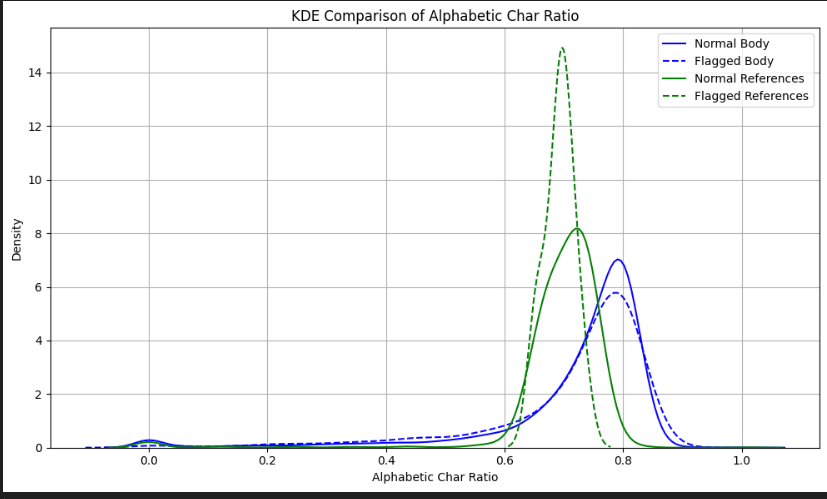

Now I will compare 4 ways: Normal Body chunks vs flagged body chunks vs normal references vs flagged references

# BELOW HERE WILL WORK AGAIN

# Word/Token Level EDA

## Tokenization (NLTK for Word analysis and metrics generation, Embedding model Tokenizer for various other metrics)

### To do **WORD TOKEN** ANALYSIS, use NLTK WORD_TOKENIZER WITH CLEANING.

### To do **EMBEDDING** TOKEN ANALYSIS, DO NOT APPLY ANY CLEANING AT ALL.

In [33]:
# string methods imports
import nltk # https://www.nltk.org/data.html
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
import re # regular expressions library builtin
import string # string library builtin

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links, remove punctuation
    and remove words containing numbers.'''

    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)

    return text

stop_words = list(set(stopwords.words('english'))) # uses nltk

def remove_stopwords(text):
  text = ' '.join(word for word in text.split(' ') if word not in stop_words)
  return text

stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/marethu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/marethu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/marethu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [34]:
from nltk.tokenize import word_tokenize

# Tokenize using nltk
def tokenize_with_nltk(text):
    return word_tokenize(text)

In [35]:
# Apply the clean_text function to the 'abstract' field in both train and test splits
def nltk_preprocess_data(example, embedding=False):
    example['nltk_cleaned_plaintext'] = clean_text(example['plaintext']) # Clean text by scrubbing various uncessary elements (w.r.t traditional ML tokenization)
    example['nltk_cleaned_plaintext'] = remove_stopwords(example['nltk_cleaned_plaintext']) # Remove stopwords to reduce dimensionality / computational complexity
    example['nltk_cleaned_plaintext'] = stemm_text(example['nltk_cleaned_plaintext']) # stemm the text to reduce dimensionality

    example['nlkt_tokenized_plaintext'] = tokenize_with_nltk(example['nltk_cleaned_plaintext'])

    return example

In [36]:
local_chunk_dataset = local_chunk_dataset.map(nltk_preprocess_data)

Map:   0%|          | 0/12985 [00:00<?, ? examples/s]

## Cleaning the plaintext and tokenizing

We might want to add this text cleaning step in as a step to our chunk embedding process actually.

In [37]:
local_chunk_dataset

Dataset({
    features: ['markdown_text', 'pdf_metadata', 'header_metadata', 'chunk_metadata', 'plaintext', 'chunk_type', 'alphabetic_char_ratio', 'numeric_char_ratio', 'punctuation_char_ratio', 'whitespace_char_ratio', 'newline_ratio', 'symbol_ratio', 'pipe_to_alnum_ratio', 'char_length', 'char_entropy', 'unique_char_ratio', 'top1_char_ratio', 'top3_char_ratio', 'nltk_cleaned_plaintext', 'nlkt_tokenized_plaintext'],
    num_rows: 12985
})

In [38]:
local_chunk_dataset[0]['nlkt_tokenized_plaintext']

['frustrat',
 'easi',
 'domain',
 'adaptationh',
 'daum´',
 'iii',
 'school',
 'comput',
 'univers',
 'utah',
 'salt',
 'lake',
 'citi',
 'utah']

In [39]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Generator to get all words from chunks (as in, if a word is repeated in a single chunk, it is counted multiple times)
def generate_all_words(token_lists):
    for tokens in token_lists:
        for token in tokens:
            yield token


# Generator to get unique words from chunks (as in, if a word is repeated in a single chunk, it is only counted once for that chunk)
def generate_unique_words(dataset):
    for tokens in dataset:
        unique_tokens = set(tokens)  # Get unique words in each abstract
        for token in unique_tokens:
            yield token


def plot_top_frequent_words(dataset, token_field='nlkt_tokenized_plaintext', top_k=20, unique=False):
    """
    Plots the top K most frequent words by percentage across a tokenized dataset field.

    Parameters:
    - dataset: The Hugging Face dataset containing tokenized text.
    - token_field (str): The field in the dataset that contains tokenized words.
    - top_k (int): The number of top words to display in the chart.
    """

    # Count word frequency
    token_lists = dataset[token_field]

    if unique:
        word_frequency_counter = Counter(generate_unique_words(token_lists))
    else:
        word_frequency_counter = Counter(generate_all_words(token_lists))
        
    
    total_documents = len(dataset)

    # Convert to DataFrame and normalize by document count
    word_df = pd.DataFrame(word_frequency_counter.items(), columns=['Word', 'Count'])
    word_df['Frequency (%)'] = 100 * word_df['Count'] / total_documents

    # Sort and get top K words
    top_k_df = word_df.sort_values(by='Frequency (%)', ascending=False).head(top_k)

    # Plotting
    plt.figure(figsize=(8, 8))
    ax = top_k_df['Frequency (%)'].plot(kind='barh', color='royalblue')

    plt.xlabel('Frequency (%)')
    plt.ylabel('Words')

    title_is_unique = 'Unique' if unique else ''

    plt.title(f'Top {top_k} Most Frequent {title_is_unique} Words (% of {total_documents} data points)')

    for index, value in enumerate(top_k_df['Frequency (%)']):
        plt.text(value + 0.05, index, f"{value:.2f}%", va='center', fontsize=9)

    ax.set_yticklabels(top_k_df['Word'])
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

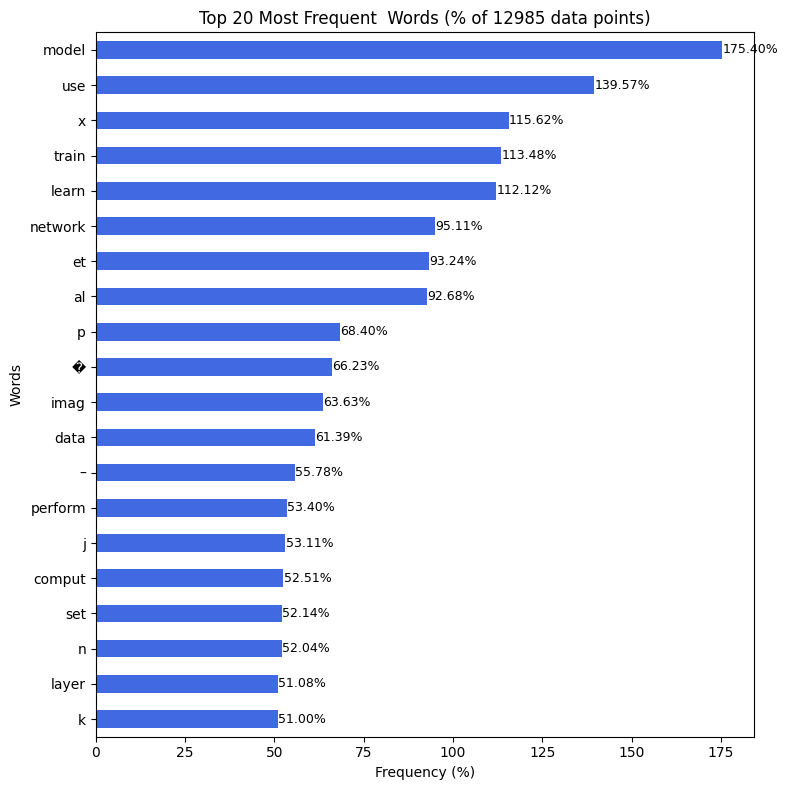

In [40]:
plot_top_frequent_words(local_chunk_dataset, token_field='nlkt_tokenized_plaintext', top_k=20, unique=False)

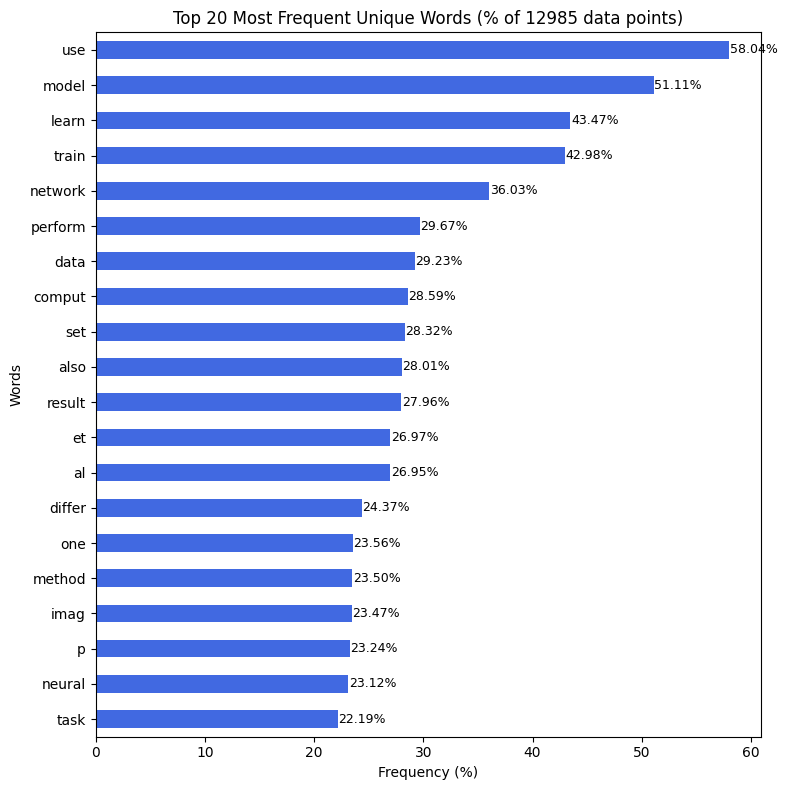

In [41]:
plot_top_frequent_words(local_chunk_dataset, token_field='nlkt_tokenized_plaintext', top_k=20, unique=True)

In [42]:
from wordcloud import WordCloud

def plot_wordcloud(dataset, token_field='nlkt_tokenized_plaintext', unique=False, max_words=100, background_color='white'):
    """
    Plots a word cloud from tokenized text data.

    Parameters:
    - dataset: Hugging Face dataset containing tokenized text.
    - token_field (str): Field with tokenized text (list of tokens per example).
    - unique (bool): If True, count each word once per chunk; if False, count all occurrences.
    - max_words (int): Maximum number of words in the word cloud.
    - background_color (str): Background color of the word cloud.
    """
    token_lists = dataset[token_field]
    
    if unique:
        word_frequency_counter = Counter(generate_unique_words(token_lists))
    else:
        word_frequency_counter = Counter(generate_all_words(token_lists))

    # Generate the word cloud
    wc = WordCloud(
        width=800,
        height=400,
        max_words=max_words,
        background_color=background_color
    ).generate_from_frequencies(word_frequency_counter)

    # Plot
    plt.figure(figsize=(15, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    title_text = "Unique Word Cloud" if unique else "Word Cloud"
    plt.title(title_text, fontsize=16)
    plt.tight_layout()
    plt.show()


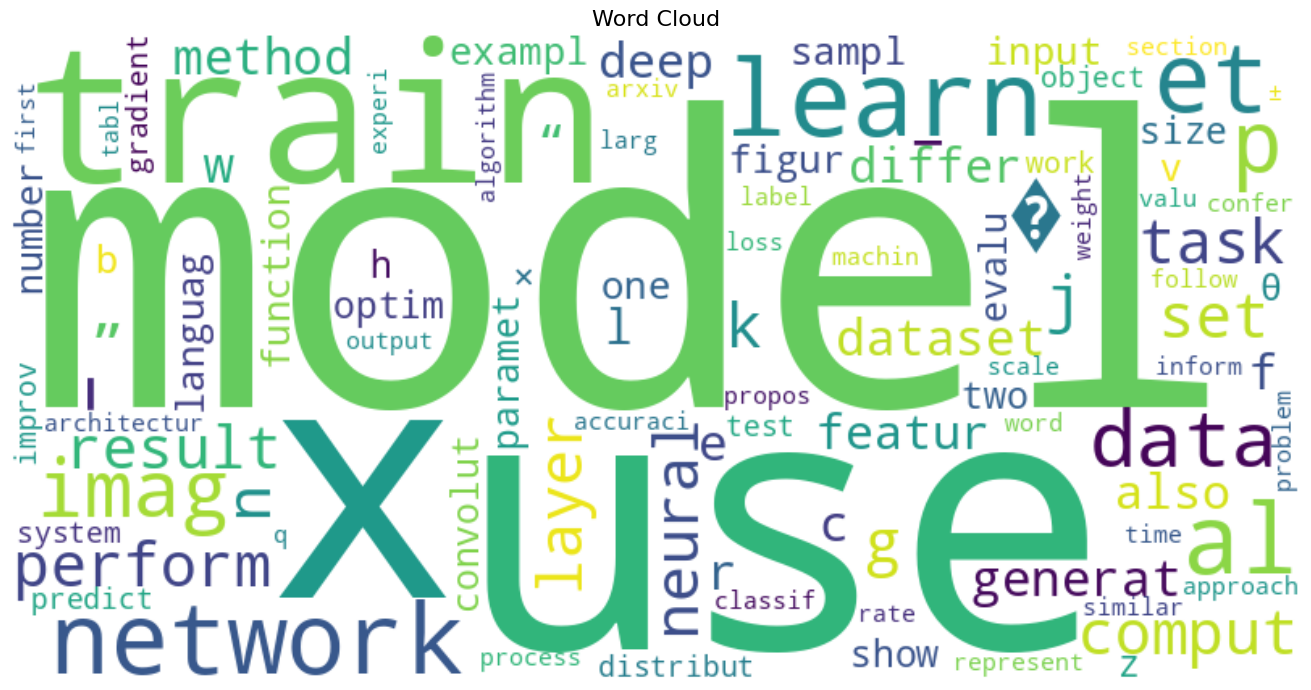

In [43]:
plot_wordcloud(local_chunk_dataset, token_field='nlkt_tokenized_plaintext', unique=False)

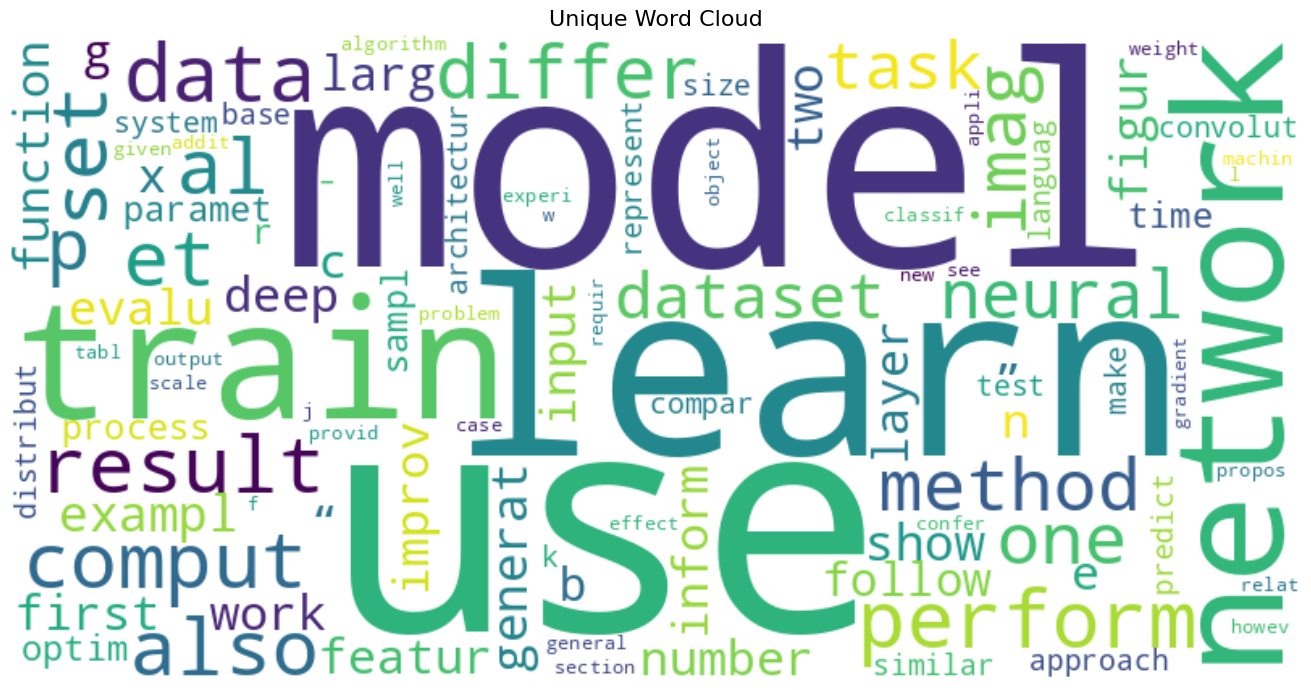

In [44]:
plot_wordcloud(local_chunk_dataset, token_field='nlkt_tokenized_plaintext', unique=True)

# Embedding Tokenizer Token Examination

We might be able to go into attention weights analysis here, which could be interesting. It might also be interesting to remove stopwords and see if the wordcloud changes much for the embedding tokenizer.

In [45]:
# Tokenize using embedding model tokenizer
def tokenize_with_embedding_tokenizer(example):
    """
    Adds a list of tokenized words from the embedding model's tokenizer under 'embedding_tokenized_plaintext'.
    """
    if 'plaintext' in example and isinstance(example['plaintext'], str):
        tokens = TOKENIZER.tokenize(example['plaintext'])
    else:
        tokens = []
    return {'embedding_tokenized_plaintext': tokens}

In [46]:
local_chunk_dataset = local_chunk_dataset.map(tokenize_with_embedding_tokenizer)

Map:   0%|          | 0/12985 [00:00<?, ? examples/s]

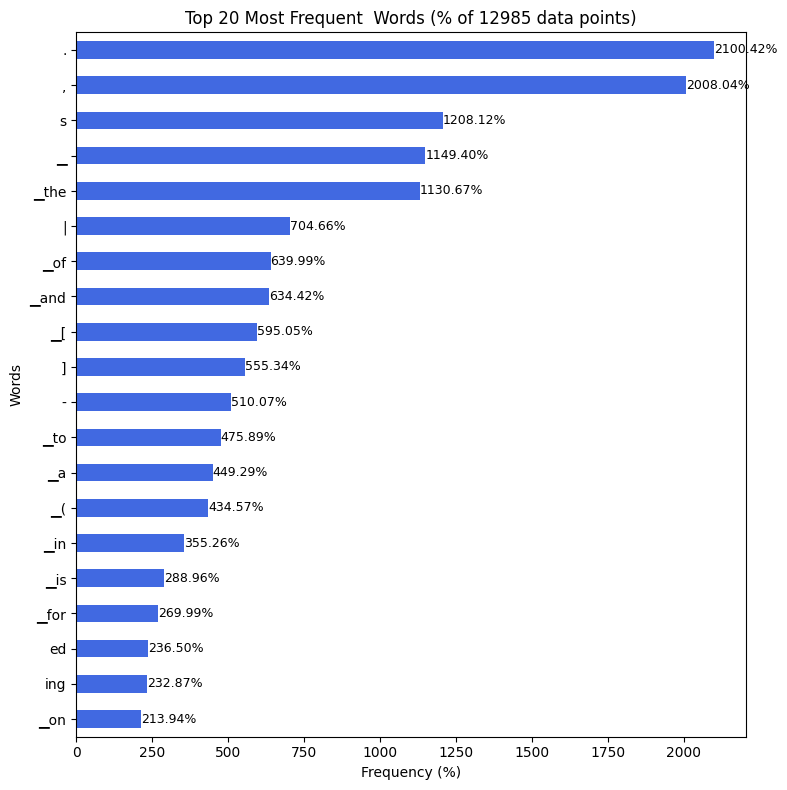

In [47]:
plot_top_frequent_words(local_chunk_dataset, token_field='embedding_tokenized_plaintext', top_k=20, unique=False)

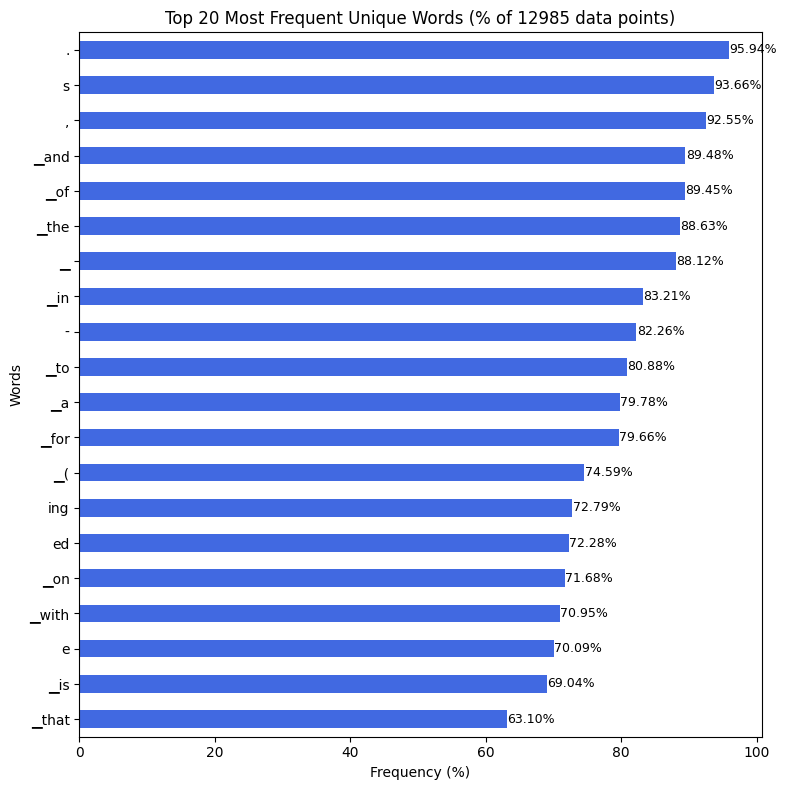

In [48]:
plot_top_frequent_words(local_chunk_dataset, token_field='embedding_tokenized_plaintext', top_k=20, unique=True)

# Moving forward involves doing more word analysis, and embedding token analysis, as well as final filter development

In [58]:
# This will remove the cache from the local folder (its a cleanup function)
local_chunk_dataset.cleanup_cache_files()

0